# General Description
i have this dataset of around 5000 records of patients for diagnostic of fatty liver and causes of this matter, in step one i want to do specific tasks for cleaning it and then in step 2 i want to run some algorithms on it. The dataset is an excel file and fields are in persian and the sheet is in Right-to-left mode.

## First we import libraries

In [ ]:
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.preprocessing import LabelEncoder
import seaborn as sns

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install openpyxl xgboost
%pip install bayesian-optimization
%pip install imbalanced-learn
%pip install deap

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Step 1: Cleaning the data set

### Having a look at what we have

In [ ]:
# Load the dataset
# file_path = './database fatty liver.xlsx'
file_path = './export(13).xlsx'
df = pd.read_excel(file_path)

# Display the first few rows to understand the structure and identify columns A and B
df.head()

,نام,تاریخ تکمیل پرسشنامه,HCV ab,HCV ab Date,FBS,HB A1C,Insulin Level,Triglyceride,Cholesterol,HDL,...,بستنی محلی نصف لیوان,میزان مصرف (ماه).20,خامه 2 ق غ,میزان مصرف (ماه).21,دوغ 2 لیوان,میزان مصرف (ماه).22,ماست موسیر 4/3 لیوان,میزان مصرف (ماه).23,نام خانوادگی,کد ملی 10 رقمی
0,افلاطون,1395-12-08,Neg,NaN,107.0,NaN,NaN,183.0,181.0,29.0,...,بلی,NaN,خیر,NaN,بلی,NaN,بلی,NaN,قیصری,1.111110e+09
1,افلاطون,1395-12-08,Neg,NaN,NaN,NaN,NaN,179.0,182.0,50.0,...,بلی,NaN,خیر,NaN,بلی,NaN,بلی,NaN,قیصری,1.111110e+09
2,افلاطون,1395-12-08,Neg,NaN,121.0,NaN,NaN,149.0,175.0,NaN,...,بلی,NaN,خیر,NaN,بلی,NaN,بلی,NaN,قیصری,1.111110e+09
3,علی اصغر,1395-10-29,Neg,NaN,86.0,4.8,NaN,223.0,208.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,نجفی,1.111111e+09
4,مجید,1395-11-06,Neg,NaN,NaN,4.9,NaN,NaN,NaN,NaN,...,بلی,1,بلی,NaN,خیر,NaN,خیر,NaN,اردشیری,1.111111e+09


In order to drop multiple returns, we merge the fields of firstname and lastname into field of fullname, so that from each fullname we only keep one first record and drop the rest.

In [ ]:
# Merge fields A (نام) and B (نام خانوادگی) into a new column 'نام کامل'
df['نام کامل'] = df['نام'] + ' ' + df['نام خانوادگی']

# Drop the original columns 'نام' and 'نام خانوادگی'
df_cleaned = df.drop(columns=['نام', 'نام خانوادگی'])

# Display the first few rows of the cleaned dataframe directly
df_cleaned.head()
df_cleaned.head()

,تاریخ تکمیل پرسشنامه,HCV ab,HCV ab Date,FBS,HB A1C,Insulin Level,Triglyceride,Cholesterol,HDL,LDL,...,بستنی محلی نصف لیوان,میزان مصرف (ماه).20,خامه 2 ق غ,میزان مصرف (ماه).21,دوغ 2 لیوان,میزان مصرف (ماه).22,ماست موسیر 4/3 لیوان,میزان مصرف (ماه).23,کد ملی 10 رقمی,نام کامل
0,1395-12-08,Neg,NaN,107.0,NaN,NaN,183.0,181.0,29.0,115.4,...,بلی,NaN,خیر,NaN,بلی,NaN,بلی,NaN,1.111110e+09,افلاطون قیصری
1,1395-12-08,Neg,NaN,NaN,NaN,NaN,179.0,182.0,50.0,111.0,...,بلی,NaN,خیر,NaN,بلی,NaN,بلی,NaN,1.111110e+09,افلاطون قیصری
2,1395-12-08,Neg,NaN,121.0,NaN,NaN,149.0,175.0,NaN,NaN,...,بلی,NaN,خیر,NaN,بلی,NaN,بلی,NaN,1.111110e+09,افلاطون قیصری
3,1395-10-29,Neg,NaN,86.0,4.8,NaN,223.0,208.0,52.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.111111e+09,علی اصغر نجفی
4,1395-11-06,Neg,NaN,NaN,4.9,NaN,NaN,NaN,NaN,NaN,...,بلی,1,بلی,NaN,خیر,NaN,خیر,NaN,1.111111e+09,مجید اردشیری


Now we save the cleaned dataset under the name cleaned_fullname_merged_database_fatty_liver.xlsx

In [ ]:
# Save the cleaned dataset to a new Excel file
cleaned_file_path = './cleaned_fullname_merged_database_fatty_liver.xlsx'
df_cleaned.to_excel(cleaned_file_path, index=False)

cleaned_file_path

'./cleaned_fullname_merged_database_fatty_liver.xlsx'

Now we process the file to keep only the first row for each unique "نام کامل" and save it in new file under the name unique_fullname_database_fatty_liver.xlsx.

In [ ]:
# Load the cleaned dataset
cleaned_file_path = './cleaned_fullname_merged_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(cleaned_file_path)

print("Number of records initially: ", df_cleaned.shape[0])

# Keep only the first row for each unique 'نام کامل'
df_unique = df_cleaned.drop_duplicates(subset=['نام کامل'], keep='first')

# Save the updated dataset
unique_file_path = './unique_fullname_database_fatty_liver.xlsx'
df_unique.to_excel(unique_file_path, index=False)

unique_file_path


Number of records initially:  5527


'./unique_fullname_database_fatty_liver.xlsx'

Number of records in new only unique records dataset:

In [ ]:
# Check the number of records in the updated dataframe
record_count = df_unique.shape[0]
record_count

3042

Number of records in data.xlsx dataset:

In [ ]:
# Check the number of records in the data.xlsx
legacy_data_file_path = './data.xlsx'
df_legacy_data = pd.read_excel(legacy_data_file_path)
legacy_record_count = df_legacy_data.shape[0]
legacy_record_count

3137

For about the weight, as there might be problems with using multiple weight units, let's check the column's values. We check the lower bound and upper bound for the weight values in those records that have actually a weight value and leave the ones with missing values aside, to check the state of our dataset with regard to this weight column

This code will load our cleaned dataset from previous step, filter out rows with missing weight values, and then print the summary statistics, including the lower and upper bounds for the weight column. This will help us identify any inconsistencies in the weight data.

In [ ]:
# Load the cleaned dataset
df_cleaned = df_unique

# Drop rows with missing values in the weight column
df_weight_non_null = df_cleaned.dropna(subset=['وزن'])

# Check the summary statistics for the weight column to identify possible inconsistencies
weight_column_stats = df_weight_non_null['وزن'].describe()

# Identify lower bound and upper bound for weight values
lower_bound = df_weight_non_null['وزن'].min()
upper_bound = df_weight_non_null['وزن'].max()

print("Weight Column Statistics:")
print(weight_column_stats)
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

Weight Column Statistics:
count    2506.000000
mean       82.678945
std        16.367934
min         0.015100
25%        72.000000
50%        81.000000
75%        91.000000
max       209.000000
Name: وزن, dtype: float64
Lower Bound: 0.0151
Upper Bound: 209.0


As we can see we have min value of 0.015KG which is probably our outlier with regard to the fact that our mean and std are seemingly fine and also our quartiles seem consistent.

In the next step we try to do the same with the height column.


In [ ]:
# Load the cleaned dataset
df_cleaned = df_unique

# Drop rows with missing values in the weight and height columns
df_cleaned_non_null = df_cleaned.dropna(subset=['قد']).copy()

# Convert height to a consistent unit (centimeters)
def convert_height(height):
    if height < 3:  # Assuming values less than 3 are in m
        return height * 100
    return height


# Check the summary statistics for the weight and height columns
height_column_stats = df_cleaned_non_null['قد'].describe()


# Identify lower bound and upper bound for height values
height_lower_bound = df_cleaned_non_null['قد'].min()
height_upper_bound = df_cleaned_non_null['قد'].max()

print("\nHeight Column Statistics (before conversion):")
print(height_column_stats)
print(f"Height Lower Bound: {height_lower_bound}")
print(f"Height Upper Bound: {height_upper_bound}")

df_cleaned_non_null['قد'] = df_cleaned_non_null['قد'].apply(convert_height)

# Check the summary statistics for the weight and height columns
height_column_stats = df_cleaned_non_null['قد'].describe()


# Identify lower bound and upper bound for height values
height_lower_bound = df_cleaned_non_null['قد'].min()
height_upper_bound = df_cleaned_non_null['قد'].max()

print("\nHeight Column Statistics (after conversion):")
print(height_column_stats)
print(f"Height Lower Bound: {height_lower_bound}")
print(f"Height Upper Bound: {height_upper_bound}")


Height Column Statistics (before conversion):
count    2506.000000
mean       58.274090
std        84.077126
min         1.010000
25%         1.610000
50%         1.740000
75%       158.000000
max      1637.000000
Name: قد, dtype: float64
Height Lower Bound: 1.01
Height Upper Bound: 1637.0

Height Column Statistics (after conversion):
count    2506.000000
mean      165.999601
std        31.681959
min        17.000000
25%       158.000000
50%       165.000000
75%       174.000000
max      1637.000000
Name: قد, dtype: float64
Height Lower Bound: 17.0
Height Upper Bound: 1637.0


Now let's save the cleaned version of our dataset under the name updated_heights_database_fatty_liver.xlsx.

In [ ]:
# Merge the updated heights back into the original dataset
df_cleaned.update(df_cleaned_non_null)
print(f"After updating records count: {df_cleaned.shape[0]}")

# Save the updated dataset
updated_file_path = 'updated_heights_database_fatty_liver.xlsx'
df_cleaned.to_excel(updated_file_path, index=False)

print(f"Updated dataset saved to {updated_file_path}")

After updating records count: 3042
Updated dataset saved to updated_heights_database_fatty_liver.xlsx


Now that weight and height fields are checked and cleaned lets recalculated BMI for those records that have non-null value of BMI:

To recalculate the BMI for records with non-null BMI values using the updated height values, we follow these steps:

1.  Load the original cleaned dataset with updated height values.
2.  Recalculate the BMI for rows with non-null BMI values.
3.  Save the updated dataset.

Here's how we achieve achieve this:

In [ ]:
# Load the dataset with updated height values
updated_file_path = 'updated_heights_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Recalculate BMI for records with non-null BMI values
def calculate_bmi(weight, height):
    return weight / (height / 100) ** 2  # height in cm

# Ensure we have non-null values for weight and height before calculating BMI
df_cleaned_non_null_bmi = df_cleaned.dropna(subset=['وزن', 'قد', 'BMI']).copy()
df_cleaned_non_null_bmi['BMI'] = df_cleaned_non_null_bmi.apply(
    lambda row: calculate_bmi(row['وزن'], row['قد']), axis=1
)

# Merge the recalculated BMI values back into the original dataset
df_cleaned.update(df_cleaned_non_null_bmi)
print(f"After updating records count: {df_cleaned.shape[0]}")

# Save the updated dataset
final_updated_file_path = 'updated_bmi_database_fatty_liver.xlsx'
df_cleaned.to_excel(final_updated_file_path, index=False)

print(f"Updated dataset saved to {final_updated_file_path}")

After updating records count: 3042
Updated dataset saved to updated_bmi_database_fatty_liver.xlsx


Now let's have a look at our BMI values:

In [ ]:
# Load the cleaned dataset
updated_file_path = 'updated_bmi_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Drop rows with missing values in the BMI column
df_bmi_non_null = df_cleaned.dropna(subset=['BMI'])

# Check the summary statistics for the BMI column to identify possible inconsistencies
bmi_column_stats = df_bmi_non_null['BMI'].describe()

# Identify lower bound and upper bound for BMI values
lower_bound = df_bmi_non_null['BMI'].min()
upper_bound = df_bmi_non_null['BMI'].max()

print("BMI Column Statistics:")
print(bmi_column_stats)
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

BMI Column Statistics:
count    2506.000000
mean       31.848603
std        60.865076
min         0.004987
25%        26.709402
50%        29.407596
75%        32.744737
max      2975.778547
Name: BMI, dtype: float64
Lower Bound: 0.004987448804333466
Upper Bound: 2975.778546712802


Except for the boundary values, it seems fine and consistent. And the min/max values seem also logical, raising probably due to the outlier weight values.

Now let's clean the dataset with regard to the field 'مصرف الکل'.

First let's have a look of possible values of this field, and then updated accordingly:

In [ ]:
# Load the cleaned dataset
updated_file_path = 'updated_bmi_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Check all possible values in the 'مصرف الکل' field
alcohol_consumption_values = df_cleaned['مصرف الکل'].unique()

print("Possible values for 'مصرف الکل':")
print(alcohol_consumption_values)

Possible values for 'مصرف الکل':
[nan 'بلی' 'خیر']


Now for the field of 'مصرف الکل' lets update this field for all the records with these three rules:
1. For those which have value of 'بلی' write 'yes'
2. For those which have value of 'خیر' write 'no'
3. For those which have no value write 'no'

In [ ]:
# Load the cleaned dataset
updated_file_path = 'updated_bmi_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Define a function to update the 'مصرف الکل' field
def update_alcohol_consumption(value):
    if value == 'بلی':
        return 'yes'
    elif value == 'خیر' or pd.isnull(value):
        return 'no'
    return value

# Apply the function to the 'مصرف الکل' field
df_cleaned['مصرف الکل'] = df_cleaned['مصرف الکل'].apply(update_alcohol_consumption)

# Save the updated dataset
updated_file_path_alcohol = 'updated_alcohol_consumption_database_fatty_liver.xlsx'
df_cleaned.to_excel(updated_file_path_alcohol, index=False)
print(f"After updating records count: {df_cleaned.shape[0]}")

print(f"Updated dataset saved to {updated_file_path_alcohol}")

# Check all possible values in the 'مصرف الکل' field after cleansing
alcohol_consumption_values = df_cleaned['مصرف الکل'].unique()

print("Possible values for 'مصرف الکل' after cleansing:")
print(alcohol_consumption_values)

After updating records count: 3042
Updated dataset saved to updated_alcohol_consumption_database_fatty_liver.xlsx
Possible values for 'مصرف الکل' after cleansing:
['no' 'yes']


Now let's clean dataset with respect to the field of 'فشار خون' as below:

To clean and convert the values in the 'فشار خون' field we define some rules and act accordingly to the specified rules:

1.  Correct the date-like values by removing the year part.
2.  Convert values from mmHg to cmHg where applicable.
3.  Leave single number values unchanged.

Here's how we try to achieve this:

In [ ]:
# Load the dataset
updated_file_path = 'updated_alcohol_consumption_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Function to clean and convert blood pressure values
def clean_blood_pressure(value):
    value = str(value)
    if isinstance(value, str):
        # Detect date-like values and extract the relevant part
        if re.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', value):
            parts = value.split('-')
            if len(parts) == 3:
                day = str(float(parts[2].split(' ')[0]))
                month =str(float(parts[1]))
                value = f"{month}/{day}"
                # print(value)

        # Convert mmHg to cmHg
        if re.match(r'\d+/\d+', value):
            parts = value.split('/')
            if int(parts[0]) > 30:  # Assuming values greater than 30 are in mmHg
                parts[0] = str(float(parts[0]) / 10)
            value = '/'.join(parts)
            # print(value)
    return value

# Apply the function to the 'فشار خون' field
df_cleaned_non_null = df_cleaned.dropna(subset=['فشار خون']).copy()
df_cleaned_non_null['فشار خون'] = df_cleaned_non_null['فشار خون'].apply(clean_blood_pressure)

blood_pressure_stats = df_cleaned_non_null['فشار خون'].describe()

print("Blood pressure Column Statistics:")
print(blood_pressure_stats)

# Merge the recalculated BP values back into the original dataset
df_cleaned.update(df_cleaned_non_null)
print(f"After updating records count: {df_cleaned.shape[0]}")

# Save the updated dataset
updated_file_path_bp = 'updated_blood_pressure_database_fatty_liver.xlsx'
df_cleaned.to_excel(updated_file_path_bp, index=False)
print(f"After updating saved records count: {df_cleaned.shape[0]}")

print(f"Updated dataset saved to {updated_file_path_bp}")

Blood pressure Column Statistics:
count          940
unique         114
top       12.0/8.0
freq           127
Name: فشار خون, dtype: object
After updating records count: 3042
After updating saved records count: 3042
Updated dataset saved to updated_blood_pressure_database_fatty_liver.xlsx


Now let's get some stats from data with regard to age and gender columns.

In [ ]:
# Load the cleaned dataset
updated_file_path = 'updated_blood_pressure_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Drop rows with missing values in the age column
df_age_non_null = df_cleaned.dropna(subset=['سن']).copy()

# Check the summary statistics for the age column to identify possible inconsistencies
age_column_stats = df_age_non_null['سن'].describe()

# Identify lower bound and upper bound for age values
lower_bound = df_age_non_null['سن'].min()
upper_bound = df_age_non_null['سن'].max()

print("Age Column Statistics:")
print(age_column_stats)
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")

Age Column Statistics:
count    3042.000000
mean       47.462196
std        12.499815
min         0.000000
25%        39.000000
50%        48.000000
75%        56.000000
max        94.000000
Name: سن, dtype: float64
Lower Bound: 0
Upper Bound: 94


In [ ]:
# Load the cleaned dataset
updated_file_path = 'updated_blood_pressure_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Drop rows with missing values in the gender column
df_gender_non_null = df_cleaned.dropna(subset=['جنسیت']).copy()

# Check the summary statistics for the gender column to identify possible inconsistencies
gender_column_stats = df_gender_non_null['جنسیت'].describe()
gender_column_freqs = df_gender_non_null['جنسیت'].value_counts()

print("Gender Column Statistics:")
print(gender_column_stats)
print("Gender Column Frequencies:")
print(gender_column_freqs)

Gender Column Statistics:
count     3042
unique       2
top         زن
freq      1717
Name: جنسیت, dtype: object
Gender Column Frequencies:
جنسیت
زن     1717
مرد    1325
Name: count, dtype: int64


NOw let's revise the columns of food consumption and amount of usage of each nutrition elements by cleaning it according to these rules:
1.  Date-like values be converted to a range format (e.g., "2024-02-04" to "2-4").
2.  Values of "بلی" be changed to "yes".
3.  Values of "خیر" be changed to "no".
4.  String single numbers and empty cells be left unchanged.

In [ ]:
# Load the dataset
updated_file_path = 'updated_blood_pressure_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Define the columns to be processed
columns_to_process = df_cleaned.columns[57:-2]  # From BA to DT (52 to 119 in 0-indexed)
# print(columns_to_process)

# Function to clean and update the values according to the specified rules
def clean_values(value):
    if pd.isnull(value):
        return value  # Keep empty cells as they are
    else:
        value = str(value)
    if isinstance(value, str):
        # Detect date-like values and convert to range
        if re.match(r'\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}', value):
            parts = value.split('-')
            if len(parts) == 3:
                day = str(float(parts[2].split(' ')[0]))
                month =str(float(parts[1]))
                value = f"{month}-{day}"
                # print(value)
        # If value is 'بلی' change to 'yes'
        elif value == 'بلی':
            value = 'yes'
        # If value is 'خیر' change to 'no'
        elif value == 'خیر':
            value = 'no'
    return value

# Apply the function to the specified columns
for column in columns_to_process:
    df_cleaned[column] = df_cleaned[column].apply(clean_values)

# Save the updated dataset
updated_file_path_ranges = 'updated_ranges_usage_cleansing_database_fatty_liver.xlsx'
df_cleaned.to_excel(updated_file_path_ranges, index=False)
print(f"After updating saved records count: {df_cleaned.shape[0]}")

updated_file_path_ranges

After updating saved records count: 3042


'updated_ranges_usage_cleansing_database_fatty_liver.xlsx'

Now for the last step of explicitly cleaning data let's apply the rules below to unify the dataset:
1.  Values of "بلی" be changed to "yes".
2. Values of "خیر" be changed to "no".
3. String single numbers and empty cells be left unchanged.

In [ ]:
# Load the dataset
updated_file_path = 'updated_ranges_usage_cleansing_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Define the columns to be processed
columns_to_process = df_cleaned.columns[0:57]
# print(columns_to_process)

# Function to clean and update the values according to the specified rules
def clean_values(value):
    if pd.isnull(value):
        return value  # Keep empty cells as they are
    else:
        value = str(value)
    if isinstance(value, str):
        # If value is 'بلی' change to 'yes'
        if value == 'بلی':
            value = 'yes'
        # If value is 'خیر' change to 'no'
        elif value == 'خیر':
            value = 'no'
    return value

# Apply the function to the specified columns
for column in columns_to_process:
    df_cleaned[column] = df_cleaned[column].apply(clean_values)

# Save the updated dataset
updated_file_path_ranges = 'updated_unifying_y_n_cells_database_fatty_liver.xlsx'
df_cleaned.to_excel(updated_file_path_ranges, index=False)
print(f"After updating saved records count: {df_cleaned.shape[0]}")

updated_file_path_ranges

After updating saved records count: 3042


'updated_unifying_y_n_cells_database_fatty_liver.xlsx'

Now that the dataset is clean, let's analyze the state of our dataset with regard to missing values.

In [ ]:
# Load the dataset
updated_file_path = 'updated_unifying_y_n_cells_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Check for missing values in the dataset
missing_values = df_cleaned.isnull().sum()

print("Missing values in each column:")
missing_values

Missing values in each column:


تاریخ تکمیل پرسشنامه       0
HCV ab                  2473
HCV ab Date             3042
FBS                     1594
HB A1C                  2780
                        ... 
میزان مصرف (ماه).22     2583
ماست موسیر 4/3 لیوان     275
میزان مصرف (ماه).23     2849
کد ملی 10 رقمی            13
نام کامل                   0
Length: 131, dtype: int64

Now because we have 13 missing values in Social Security Number (aka, kode meli) we drop these records as well:

In [ ]:
# Load the dataset
file_path = 'updated_unifying_y_n_cells_database_fatty_liver.xlsx'
df = pd.read_excel(file_path)

# Drop records where "کد ملی 10 رقمی" is missing
df_cleaned = df.dropna(subset=["کد ملی 10 رقمی"])

# Save the cleaned dataset to a new file
output_file_path = 'cleaned_fatty_liver_data_ready_to_join.xlsx'
df_cleaned.to_excel(output_file_path, index=False)

print(f"After updating saved records count: {df_cleaned.shape[0]}")

print(output_file_path)

# Check for missing values in the dataset
missing_values = df_cleaned.isnull().sum()

print("Missing values in each column:")
missing_values

After updating saved records count: 3029
cleaned_fatty_liver_data_ready_to_join.xlsx
Missing values in each column:


تاریخ تکمیل پرسشنامه       0
HCV ab                  2463
HCV ab Date             3029
FBS                     1588
HB A1C                  2767
                        ... 
میزان مصرف (ماه).22     2572
ماست موسیر 4/3 لیوان     274
میزان مصرف (ماه).23     2836
کد ملی 10 رقمی             0
نام کامل                   0
Length: 131, dtype: int64

Now this file is cleaned and ready to join our other file on the field of Social Security Number so that we can have the grades of fatty liver of each patient. For this matter let's first clean export(24).xls either.

In [ ]:
# Load the dataset
# file_path = './database fatty liver.xlsx'
file_path = './export(24).xlsx'
df = pd.read_excel(file_path)

# Display the first few rows to understand the structure and identify columns A and B
df.head()

,شماره پرونده,تاریخ,تاریخ تکمیل پرسشنامه,نام,نام خانوادگی,کد ملی 10 رقمی,Abd. Sonography Date,Liver Size,Fatty Liver,Fatty Liver Grade,...,Ascites,Splenomegally,Gall Bladder Stone,Liver Fibroscan Date,Fibroscan Score,Steatosis Score,Liver Biopsy Date,Liver Biopsy,Liver Biopsy Path NO.,Liver Biopsy Result
0,111,1396-08-14,1395-12-08,افلاطون,قیصری,1.111110e+09,1396-01-21,Normal,NaN,NaN,...,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,111,1396-08-14,1395-12-08,افلاطون,قیصری,1.111110e+09,1397-12-05,Normal,NaN,NaN,...,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1396-07-05,1395-10-29,علی اصغر,نجفی,1.111111e+09,1395-09-21,Normal,NaN,NaN,...,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,1396-07-11,1395-11-06,مجید,اردشیری,1.111111e+09,1395-09-23,Normal,NaN,NaN,...,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100,1396-08-09,1395-12-03,مهری,لطفی درشکی,1.111110e+09,1395-10-28,Normal,NaN,NaN,...,No,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In order to drop multiple returns, we merge the fields of firstname and lastname into field of fullname, so that from each fullname we only keep one first record and drop the rest.

In [ ]:
# Merge fields A (نام) and B (نام خانوادگی) into a new column 'نام کامل'
df['نام کامل'] = df['نام'] + ' ' + df['نام خانوادگی']

# Drop the original columns 'نام' and 'نام خانوادگی'
df_cleaned = df.drop(columns=['نام', 'نام خانوادگی'])

# Display the first few rows of the cleaned dataframe directly
df_cleaned.head()
df_cleaned.head()

,شماره پرونده,تاریخ,تاریخ تکمیل پرسشنامه,کد ملی 10 رقمی,Abd. Sonography Date,Liver Size,Fatty Liver,Fatty Liver Grade,Liver Mass,Size of Mass,...,Splenomegally,Gall Bladder Stone,Liver Fibroscan Date,Fibroscan Score,Steatosis Score,Liver Biopsy Date,Liver Biopsy,Liver Biopsy Path NO.,Liver Biopsy Result,نام کامل
0,111,1396-08-14,1395-12-08,1.111110e+09,1396-01-21,Normal,NaN,NaN,No,NaN,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,افلاطون قیصری
1,111,1396-08-14,1395-12-08,1.111110e+09,1397-12-05,Normal,NaN,NaN,No,NaN,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,افلاطون قیصری
2,1,1396-07-05,1395-10-29,1.111111e+09,1395-09-21,Normal,NaN,NaN,No,NaN,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,علی اصغر نجفی
3,10,1396-07-11,1395-11-06,1.111111e+09,1395-09-23,Normal,NaN,NaN,No,NaN,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,مجید اردشیری
4,100,1396-08-09,1395-12-03,1.111110e+09,1395-10-28,Normal,NaN,NaN,No,NaN,...,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,مهری لطفی درشکی


Now we save the cleaned dataset under the name cleaned_fullname_merged_database_fatty_liver.xlsx

In [ ]:
# Save the cleaned dataset to a new Excel file
cleaned_file_path = './export24_cleaned_fullname_merged_database_fatty_liver.xlsx'
df_cleaned.to_excel(cleaned_file_path, index=False)

cleaned_file_path

'./export24_cleaned_fullname_merged_database_fatty_liver.xlsx'

Now we process the file to keep only the first row for each unique "نام کامل" and save it in new file under the name unique_fullname_database_fatty_liver.xlsx.

In [ ]:
# Load the cleaned dataset
cleaned_file_path = './export24_cleaned_fullname_merged_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(cleaned_file_path)

print("Number of records initially: ", df_cleaned.shape[0])

# Keep only the first row for each unique 'نام کامل'
df_unique = df_cleaned.drop_duplicates(subset=['نام کامل'], keep='first')

# Save the updated dataset
unique_file_path = './export24_unique_fullname_database_fatty_liver.xlsx'
df_unique.to_excel(unique_file_path, index=False)

unique_file_path


Number of records initially:  4060


'./export24_unique_fullname_database_fatty_liver.xlsx'

Number of records in new only unique records dataset:

In [ ]:
# Check the number of records in the updated dataframe
record_count = df_unique.shape[0]
record_count

3055

Now let's check for missing values overall and in field of Social Security Number in this excel file as well:

In [ ]:
# Load the dataset
updated_file_path = 'export24_unique_fullname_database_fatty_liver.xlsx'
df_cleaned = pd.read_excel(updated_file_path)

# Check for missing values in the dataset
missing_values = df_cleaned.isnull().sum()

print("Missing values in each column:")
missing_values

Missing values in each column:


شماره پرونده                0
تاریخ                       0
تاریخ تکمیل پرسشنامه        0
کد ملی 10 رقمی             13
Abd. Sonography Date     1268
Liver Size               1349
Fatty Liver              2725
Fatty Liver Grade        2738
Liver Mass               1667
Size of Mass             3051
Number of Mass           3049
Nature                   2045
Ascites                  1405
Splenomegally            1344
Gall Bladder Stone       1347
Liver Fibroscan Date     2077
Fibroscan Score          2086
Steatosis Score          2087
Liver Biopsy Date        3039
Liver Biopsy             3039
Liver Biopsy Path NO.    3047
Liver Biopsy Result      3048
نام کامل                    0
dtype: int64

Now because we have 13 missing values in Social Security Number (aka, kode meli) we drop these records as well:

In [ ]:
# Load the dataset
file_path = 'export24_unique_fullname_database_fatty_liver.xlsx'
df = pd.read_excel(file_path)

# Drop records where "کد ملی 10 رقمی" is missing
df_cleaned = df.dropna(subset=["کد ملی 10 رقمی"])

# Save the cleaned dataset to a new file
output_file_path = 'export24_cleaned_unique_fullname_database_fatty_liver.xlsx'
df_cleaned.to_excel(output_file_path, index=False)

print(f"After updating saved records count: {df_cleaned.shape[0]}")

print(output_file_path)

# Check for missing values in the dataset
missing_values = df_cleaned.isnull().sum()

print("Missing values in each column:")
missing_values

After updating saved records count: 3042
export24_cleaned_unique_fullname_database_fatty_liver.xlsx
Missing values in each column:


شماره پرونده                0
تاریخ                       0
تاریخ تکمیل پرسشنامه        0
کد ملی 10 رقمی              0
Abd. Sonography Date     1264
Liver Size               1345
Fatty Liver              2713
Fatty Liver Grade        2726
Liver Mass               1658
Size of Mass             3038
Number of Mass           3036
Nature                   2038
Ascites                  1399
Splenomegally            1340
Gall Bladder Stone       1342
Liver Fibroscan Date     2070
Fibroscan Score          2079
Steatosis Score          2080
Liver Biopsy Date        3026
Liver Biopsy             3026
Liver Biopsy Path NO.    3034
Liver Biopsy Result      3035
نام کامل                    0
dtype: int64

In [ ]:
# Load the datasets
file1_path = 'cleaned_fatty_liver_data_ready_to_join.xlsx'
file2_path = 'export24_cleaned_unique_fullname_database_fatty_liver.xlsx'

df1 = pd.read_excel(file1_path)
df2 = pd.read_excel(file2_path)

# Display column headers of both DataFrames
df1_columns = set(df1.columns)
df2_columns = set(df2.columns)

# Find mutual columns between the two DataFrames
mutual_columns = df1_columns.intersection(df2_columns)

# Print mutual columns (excluding the unique identifier column)
print("Mutual Columns:", mutual_columns)
# print("Mutual Columns:", mutual_columns - {'کد ملی 10 رقمی'})

# Identify mutual columns, excluding the join key "کد ملی 10 رقمی"
mutual_columns = set(df1.columns).intersection(df2.columns) - {'کد ملی 10 رقمی'}

# Join the DataFrames on "کد ملی 10 رقمی", excluding duplicate mutual columns from the second DataFrame
df_merged = pd.merge(df1, df2.drop(columns=mutual_columns), on='کد ملی 10 رقمی', how='inner')


# Save the merged DataFrame to a new Excel file
output_file_path = 'merged_fatty_liver_dataset.xlsx'
df_merged.to_excel(output_file_path, index=False)

print(f"Merged file saved to {output_file_path}")

Mutual Columns: {'کد ملی 10 رقمی', 'شماره پرونده', 'تاریخ تکمیل پرسشنامه', 'نام کامل'}
Merged file saved to merged_fatty_liver_dataset.xlsx


Total count of records after merge:

In [ ]:
record_count = df_merged.shape[0]
record_count

3029

Now in order to run our classification algorithms, we should determine our target column.

For our target column one option is **"Steatosis Score"**. We drop records that have missing values in this field.

In [ ]:
# Load the final merged dataset
file_path = 'merged_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Drop rows with missing values in the "Steatosis Score" column
df_cleaned = df.dropna(subset=["Steatosis Score"])

# Save the cleaned dataset to a new Excel file
cleaned_file_path = 'cleaned_steatosis_dataset.xlsx'
df_cleaned.to_excel(cleaned_file_path, index=False)

record_count = df_cleaned.shape[0]

print(f"Cleaned dataset saved to {cleaned_file_path}")
record_count

Cleaned dataset saved to cleaned_steatosis_dataset.xlsx


955

As we saw what was left for us was a dataset with 955 records. Now let's check all the possible values of our target field.

In [ ]:
# Check all possible values in the 'Steatosis Score' field after cleansing
steatosis_score_values = df_cleaned["Steatosis Score"].unique()

print("Possible values for 'Steatosis Score' after cleansing:")
print(steatosis_score_values)
print("Number of records in dataset after cleaning:")
print(record_count)

Possible values for 'Steatosis Score' after cleansing:
['S3' 'S2' 'S0' 'S1']
Number of records in dataset after cleaning:
955


Another option for our target column would be **"Fatty Liver Grade"**. We drop records that have missing values in this field.

Also check all the possible values of our "Fatty Liver Grade" field.

In [ ]:
# Load the dataset
file_path = 'merged_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Get the unique values and their counts in the 'Fatty Liver Grade' field
sonography_grade_counts = df["Fatty Liver Grade"].value_counts(dropna=False)

# Separate unique values from the counts
sonography_grade_values = sonography_grade_counts.index

print("Possible values for 'Fatty Liver Grade' after merging and their counts:")
for value, count in sonography_grade_counts.items():
    print(f"{value}: {count}")

print("\nUnique values in 'Fatty Liver Grade':")
print(sonography_grade_values)

# Drop rows with missing values in the "Fatty Liver Grade" column
df_cleaned = df.dropna(subset=["Fatty Liver Grade"])

# Save the cleaned dataset to a new Excel file
cleaned_file_path = 'cleaned_sonography_dataset.xlsx'
df_cleaned.to_excel(cleaned_file_path, index=False)

record_count = df_cleaned.shape[0]

print(f"Cleaned dataset saved to {cleaned_file_path}")

print("Total number of records with value in their 'Fatty Liver Grade' field was:")
record_count

Possible values for 'Fatty Liver Grade' after merging and their counts:
nan: 2713
Moderate: 165
Severe: 115
Mild: 36

Unique values in 'Fatty Liver Grade':
Index([nan, 'Moderate', 'Severe', 'Mild'], dtype='object', name='Fatty Liver Grade')
Cleaned dataset saved to cleaned_sonography_dataset.xlsx
Total number of records with value in their 'Fatty Liver Grade' field was:


316

As the data for patients with fatty liver and the grade of their fatty liver can be diagnosed with both Steatosis Score (S0, S1, S2, S3) which is in the field "Steatosis Score" and Sonography result (Mild, Moderate, Severe) which is in the field "Fatty Liver Grade", we drop every record from the dataset that has no value in neither of those two and then make a new unified column where for every patient if they have value in "Fatty Liver Grade" field then maps them to (Mild to 1, Moderate to 2, Severe to 3) respectively and if they don't have value in that field but they have value in "Steatosis Score" field then if it is S1 we add 1 and S2 we add 2 and if S3 we add 3 (notice that if the value is S0 the patient has no fatty liver and we drop it) and for every record that does not have any of these situations we drop them. Then we drop these two columns and then we save the resulting dataframe. In this manner the priority will be with Sonography result.

In [ ]:
# Load the dataset
file_path = 'merged_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Drop records with no value in both "Steatosis Score" and "Fatty Liver Grade"
df_cleaned = df.dropna(subset=["Steatosis Score", "Fatty Liver Grade"], how='all')

# Create a new unified column
def map_fatty_liver_grade(row):
    if pd.notna(row["Fatty Liver Grade"]):
        grade_mapping = {"Mild": 1, "Moderate": 2, "Severe": 3}
        return grade_mapping.get(row["Fatty Liver Grade"], None)
    elif pd.notna(row["Steatosis Score"]):
        score_mapping = {"S1": 1, "S2": 2, "S3": 3}
        return score_mapping.get(row["Steatosis Score"], None)
    return None

df_cleaned['Unified Liver Grade'] = df_cleaned.apply(map_fatty_liver_grade, axis=1)

# Drop records where "Unified Liver Grade" is None or where "Steatosis Score" is S0
df_final = df_cleaned.dropna(subset=["Unified Liver Grade"])
df_final = df_final[df_final["Steatosis Score"] != "S0"]

# Drop the original "Steatosis Score" and "Fatty Liver Grade" columns
df_final.drop(columns=["Steatosis Score", "Fatty Liver Grade"], inplace=True)

# Save the resulting dataframe
cleaned_file_path = 'cleaned_unified_fatty_liver_dataset.xlsx'
df_final.to_excel(cleaned_file_path, index=False)

print(f"Cleaned dataset saved to {cleaned_file_path}")
print(f"Cleaned dataset has total number of {df_final.shape[0]} records!")


# Get the unique values and their counts in the 'Unified Liver Grade' field
unified_grade_counts = df_final["Unified Liver Grade"].value_counts(dropna=False)

# Separate unique values from the counts
unified_grade_values = unified_grade_counts.index

print("Possible values for 'Unified Liver Grade' after unifying and their counts:")
for value, count in unified_grade_counts.items():
    print(f"{value}: {count}")

C:\Users\iMohammad97\AppData\Local\Temp\ipykernel_10524\1890413438.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Unified Liver Grade'] = df_cleaned.apply(map_fatty_liver_grade, axis=1)


Cleaned dataset saved to cleaned_unified_fatty_liver_dataset.xlsx
Cleaned dataset has total number of 1087 records!
Possible values for 'Unified Liver Grade' after unifying and their counts:
3.0: 711
2.0: 311
1.0: 65


To have some sense let's visualize it:

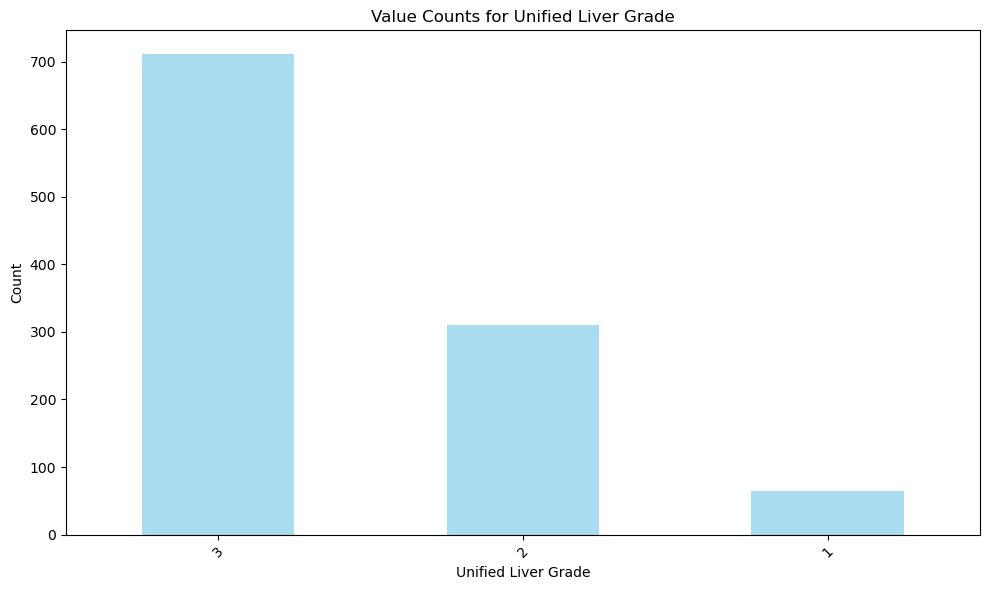

In [ ]:
# Load the dataset
file_path = 'cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Get the unique values and their counts in the 'Unified Liver Grade' field
liver_grade_counts = df["Unified Liver Grade"].value_counts(dropna=False)
%matplotlib inline
# Plot the value counts as a bar chart
plt.figure(figsize=(10, 6))
liver_grade_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Value Counts for Unified Liver Grade')
plt.xlabel('Unified Liver Grade')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

## Step 1.1: Getting information from the data set

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Filter records for "مرد" and "زن" in "جنسیت" column
df_male = df[df['جنسیت'] == 'مرد']
df_female = df[df['جنسیت'] == 'زن']

# Calculate the required values
male_count = df_male.shape[0]
male_max_age = df_male['سن'].max()
male_min_age = df_male['سن'].min()

female_count = df_female.shape[0]
female_max_age = df_female['سن'].max()
female_min_age = df_female['سن'].min()

max_weight = df['وزن'].max()
min_weight = df['وزن'].min()

max_height = df['قد'].max()
min_height = df['قد'].min()

max_bmi = df['BMI'].max()
min_bmi = df['BMI'].min()

# Create a dictionary with the results
results = {
    "Male Count": male_count,
    "Max Age (Male)": male_max_age,
    "Min Age (Male)": male_min_age,
    "Female Count": female_count,
    "Max Age (Female)": female_max_age,
    "Min Age (Female)": female_min_age,
    "Max Weight": max_weight,
    "Min Weight": min_weight,
    "Max Height": max_height,
    "Min Height": min_height,
    "Max BMI": max_bmi,
    "Min BMI": min_bmi,
}

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame([results])
results_df


,Male Count,Max Age (Male),Min Age (Male),Female Count,Max Age (Female),Min Age (Female),Max Weight,Min Weight,Max Height,Min Height,Max BMI,Min BMI
0,476,94,0,611,76,0,209.0,0.0151,195.0,17.0,2975.778547,0.004987


## Step 2: Classification

### 1. Decision Tree

Now that we have this final cleaned dataset, we can run our classification. We start with DecisionTree classification algorithm to do a full training and testing with 80/20 data division and measure the accuracy of the decision tree classification model with different accuracy metrics. The target column that we try to classify our data based on that is "Unified Liver Grade".

For this part will split the data into training and testing sets, train a Decision Tree model, and evaluate its performance using various accuracy metrics.

**Explanation of the Code:**

1.  Load the Dataset: Use pandas.read_excel to load the dataset into a DataFrame.
2.  Feature and Target Selection: Separate the DataFrame into features (X) and the target variable (y), which is "Unified Liver Grade".
3.  Data Splitting: Use train_test_split to divide the data into training and testing sets with an 80/20 split.
4.  Training the Model: Fit a DecisionTreeClassifier to the training data.
5.  Prediction: Use the trained model to predict the labels for the test set.
6.  Evaluation Metrics: Calculate accuracy, precision, recall, F1 score, classification report, and confusion matrix to evaluate the model's performance.

**Key Metrics Explained:**

*   Accuracy: The proportion of correct predictions among the total number of cases.
*   Precision: The ratio of correctly predicted positive observations to the total predicted positives.
*   Recall (Sensitivity): The ratio of correctly predicted positive observations to all actual positives.
*   F1 Score: The weighted average of Precision and Recall, useful for uneven class distributions.

As our data is kind of a mixed one, we need to do some preprocessing on the data:


1.  **Handling Mixed Data Types:** Ensure that each column has a uniform data type. We'll convert object columns to string, and handle numeric columns separately.
2.  **Date Data Types:** We remove date datas as they are irrelevant.
3. **Handling Missing Values:** We'll handle missing values in a way that respects the original data types of each column.
4. **Encoding:** We use LabelEncoder on all object type columns after ensuring they contain uniform data types.
5. **Class Names:** Ensure that class names are consistently extracted and labeled for visualization and reporting.

**Visualizing the Results:** After the traning we will visualize the decision tree structure and confusion matrix for better understanding of the model's performance.

### with Decision Tree

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


Accuracy: 0.5642201834862385
Precision: 0.5559528211518697
Recall: 0.5642201834862385
F1 Score: 0.5600250921351839

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       0.36      0.38      0.37        66
           3       0.72      0.72      0.72       136

    accuracy                           0.56       218
   macro avg       0.36      0.37      0.36       218
weighted avg       0.56      0.56      0.56       218

Confusion Matrix:
 [[ 0 12  4]
 [ 6 25 35]
 [ 6 32 98]]


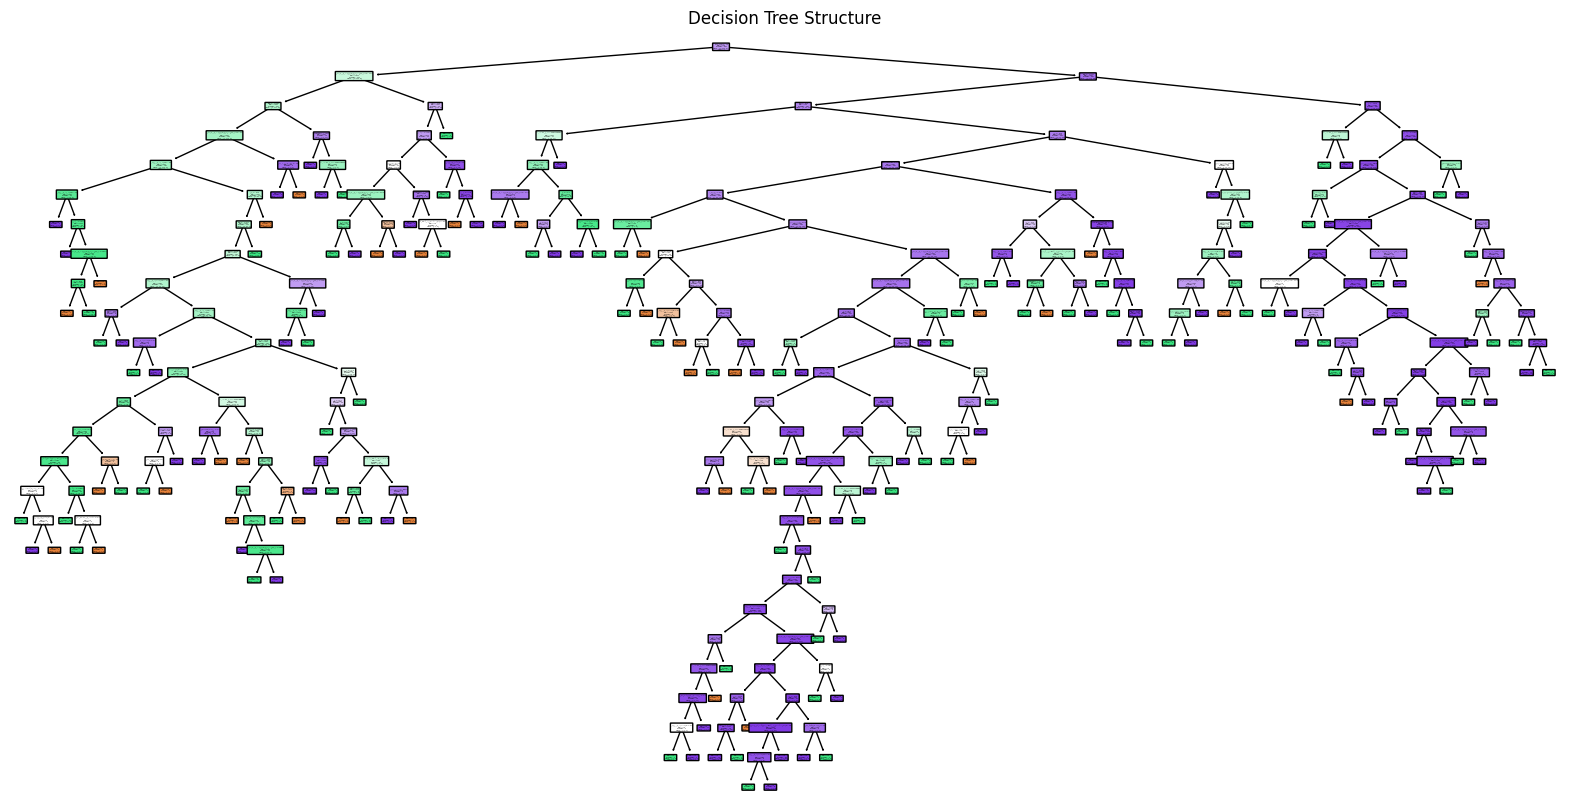

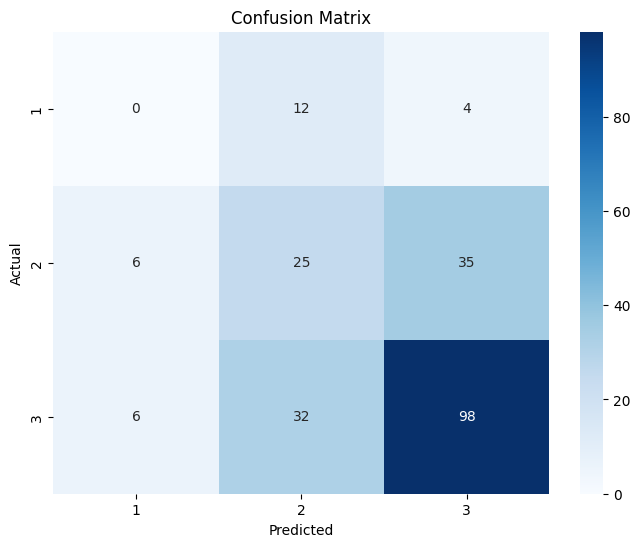

In [ ]:
# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()


# Drop or convert non-numeric columns (for example, drop a date column)
# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه'], inplace=True)
df.drop(columns=['تاریخ'], inplace=True)
df.drop(columns=['Abd. Sonography Date'], inplace=True)
df.drop(columns=['Liver Fibroscan Date'], inplace=True)
df.drop(columns=['Liver Biopsy Date'], inplace=True)
df.drop(columns=['HCV ab Date'], inplace=True)


# Handle missing values
# Fill numeric columns with mean or median
for column in df.select_dtypes(include=['number']).columns:
    df[column].fillna(df[column].median(), inplace=True)

# For object type columns, fill missing with a placeholder or mode
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna('missing', inplace=True)

# Convert all object type columns to categorical if needed
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])


# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Split the data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict the test set results
y_pred = decision_tree.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(decision_tree, feature_names=X.columns, class_names=np.unique(y).astype(str), filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.show()

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### with Decision Tree and GridSearchCV

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Accuracy: 0.6422018348623854
Precision: 0.6016935761226216
Recall: 0.6422018348623854
F1 Score: 0.6208876739132096

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       0.47      0.55      0.50        66
           3       0.74      0.76      0.75       136

    accuracy                           0.64       218
   macro avg       0.40      0.44      0.42       218
weighted avg       0.60      0.64      0.62       218

Confusion Matrix:
 [[  0   9   7]
 [  0  36  30]
 [  0  32 104]]


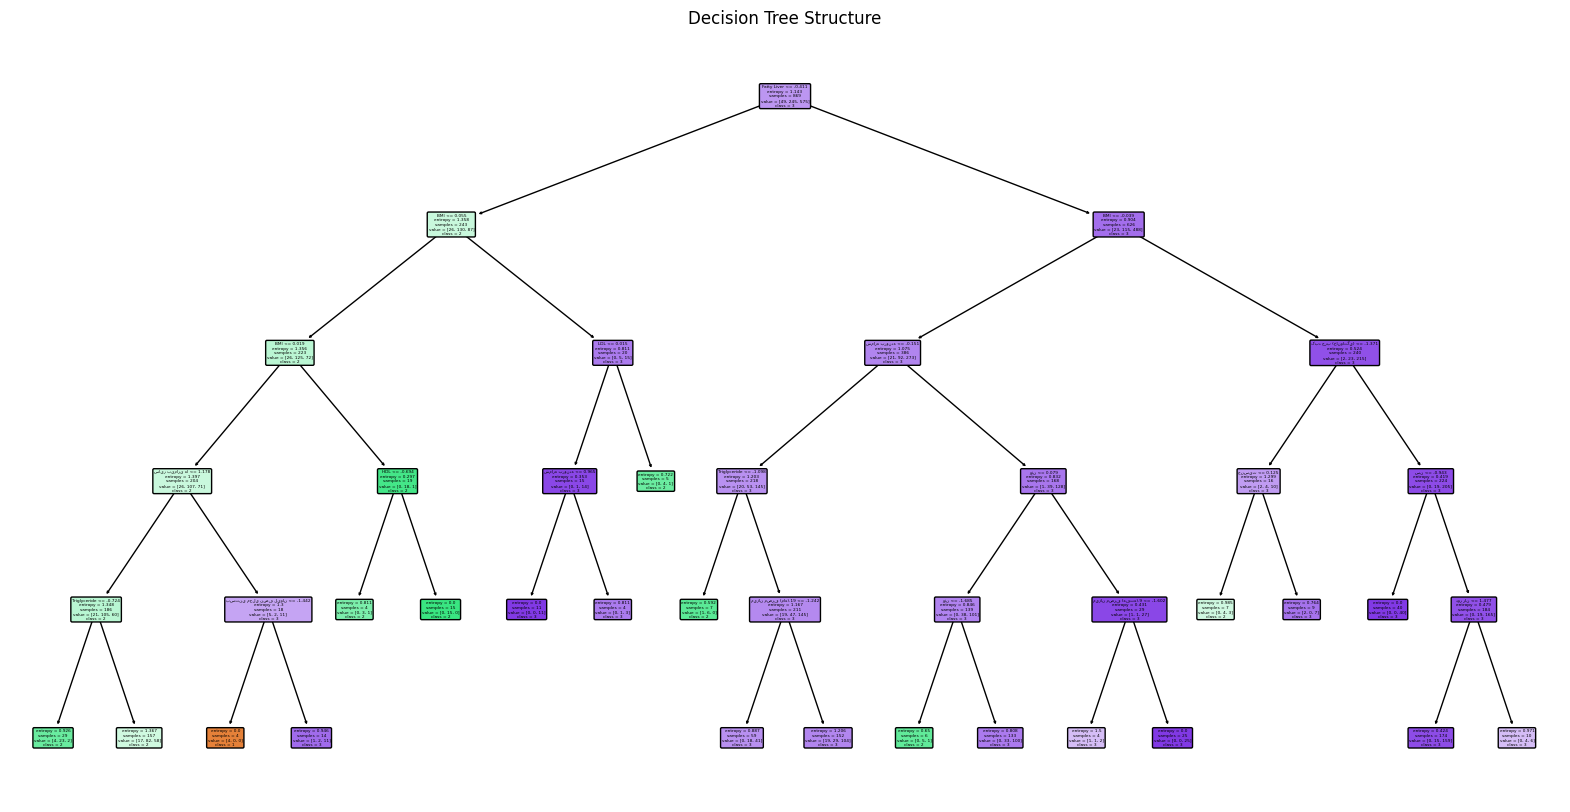

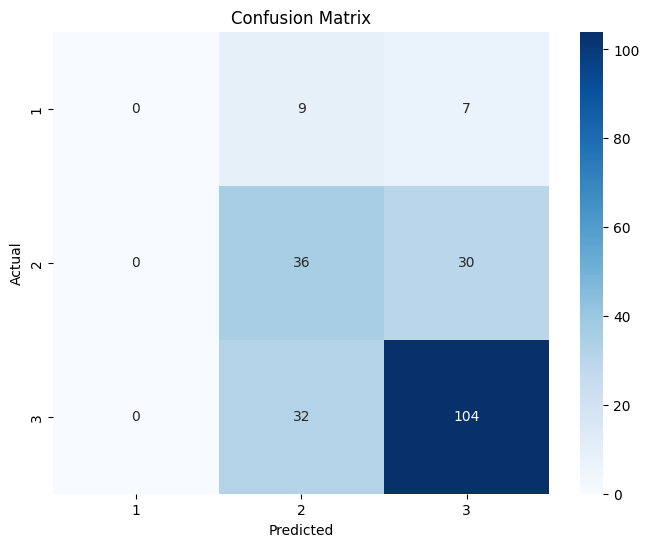

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = 'cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()


# df.drop(columns=df.columns[57:-2])
# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date'], inplace=True)

# Handle missing values
# Fill numeric columns with mean or median
for column in df.select_dtypes(include=['number']).columns:
    df[column].fillna(df[column].median(), inplace=True)

# For object type columns, fill missing with a placeholder or mode
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna('missing', inplace=True)

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Train the Decision Tree classifier with the best parameters
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)

# Predict the test set results
y_pred = best_tree.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=df.drop(columns=["Unified Liver Grade"]).columns, class_names=np.unique(y).astype(str), filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.show()

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### with Decision Tree and SMOTE

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

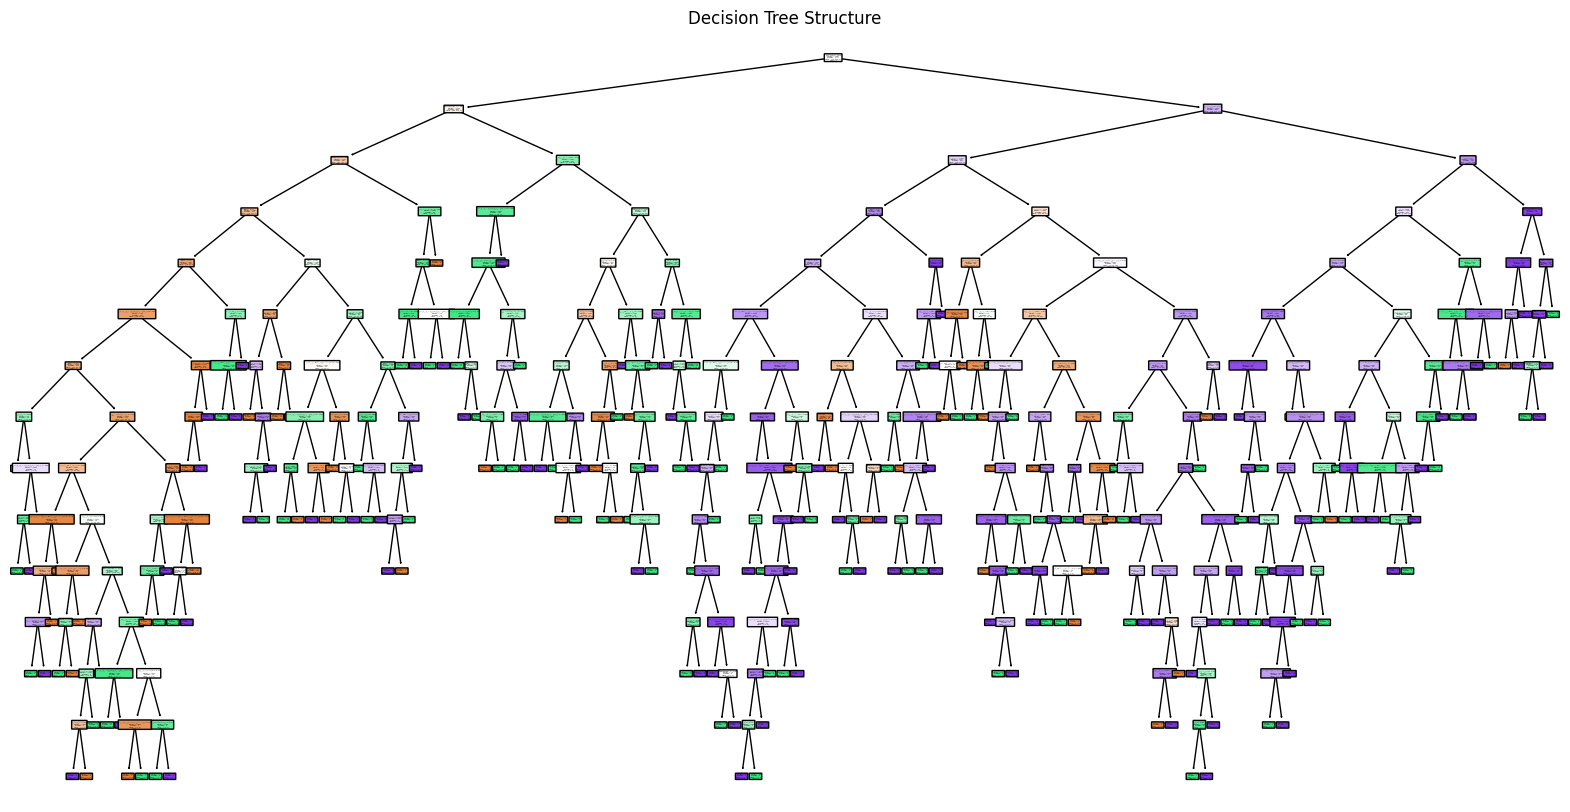

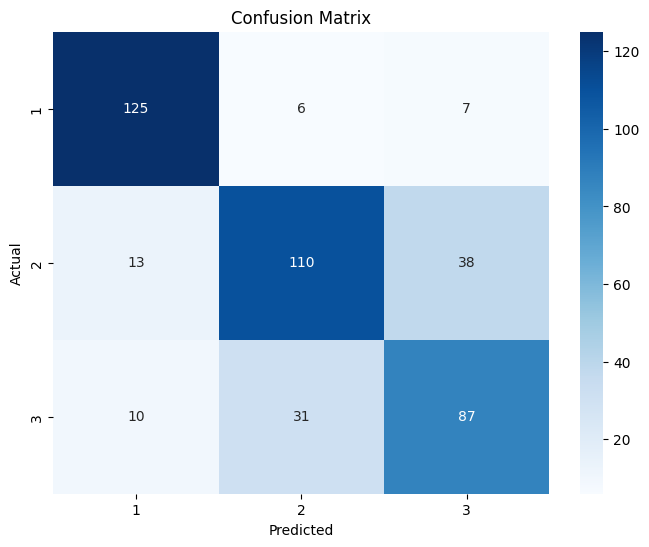

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Train the Decision Tree classifier with the best parameters
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)

# Predict the test set results
y_pred = best_tree.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=df.drop(columns=["Unified Liver Grade"]).columns, class_names=np.unique(y).astype(str), filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.show()

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### with Decision Tree and SMOTE and Undersampling of the majority class

**SMOTE + ENN:** We replaced basic SMOTE with SMOTEENN (a combination of SMOTE and Edited Nearest Neighbors). SMOTE generates synthetic minority class samples, while ENN removes samples that are misclassified by their nearest neighbors, leading to a more refined dataset.

This combination helps in balancing the dataset by oversampling minority classes while also cleaning up noise and misclassified samples.

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

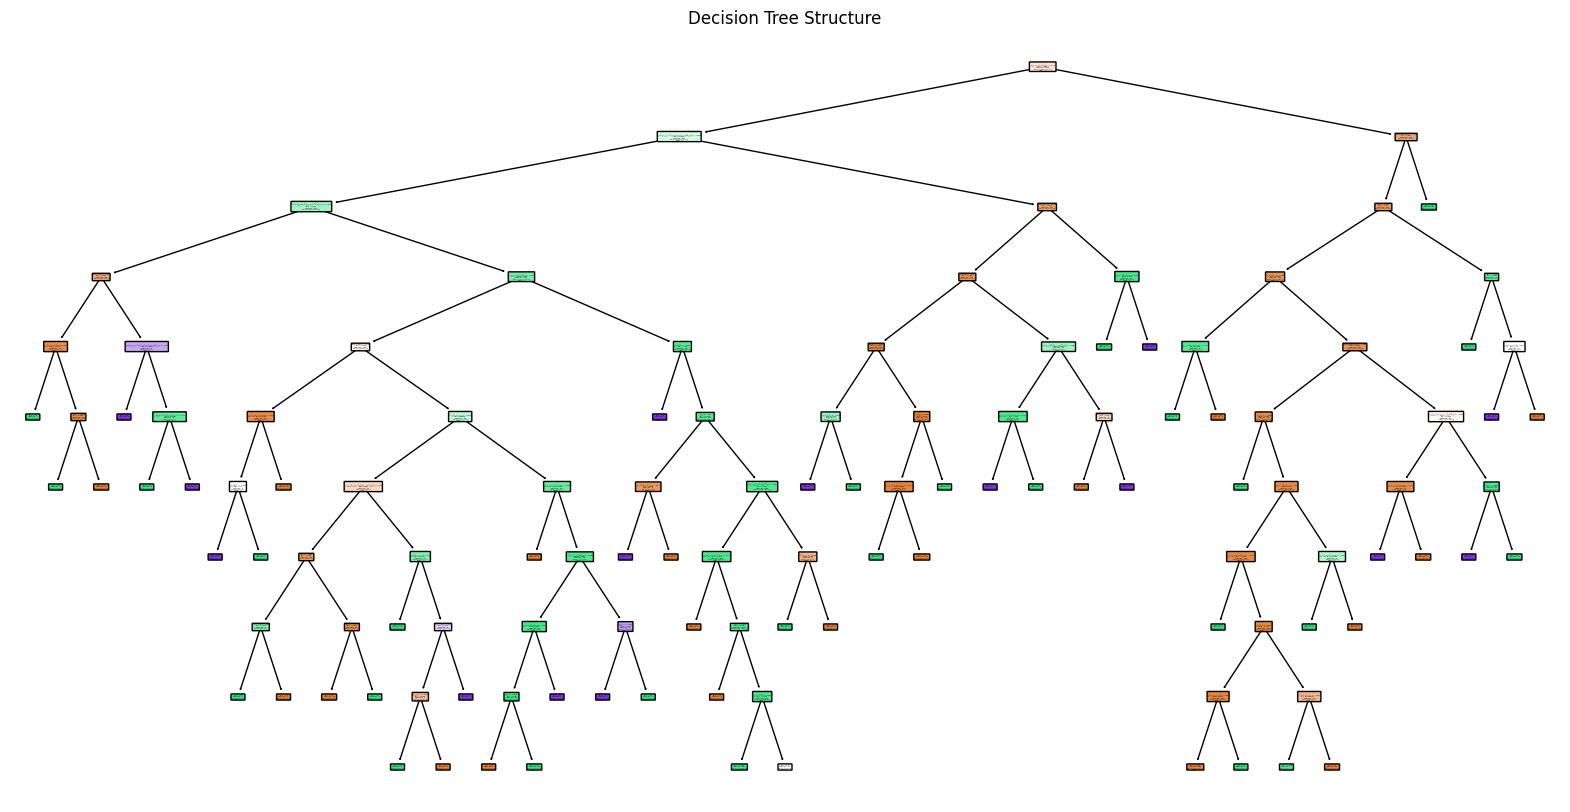

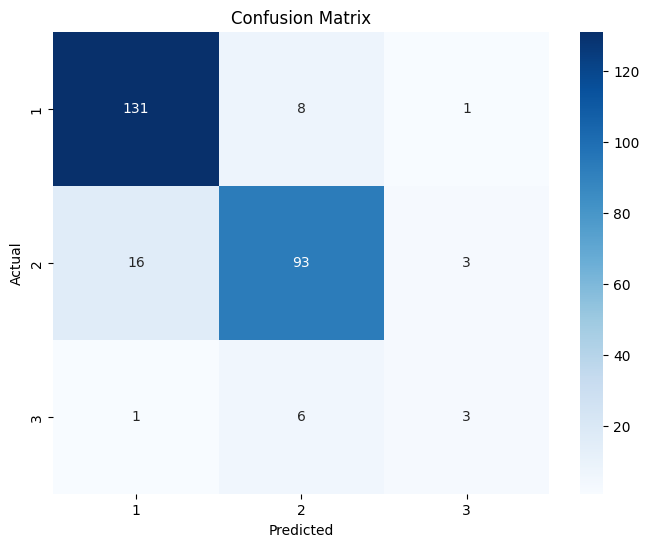

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(smote=SMOTE(random_state=42), random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Train the Decision Tree classifier with the best parameters
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)

# Predict the test set results
y_pred = best_tree.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=df.drop(columns=["Unified Liver Grade"]).columns, class_names=np.unique(y).astype(str), filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.show()

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### with Decision Tree (with Bayesian Optimized hyper-parameters) and SMOTE and Undersampling of the majority class

**Bayesian Optimization:** It provides a more efficient way to explore hyperparameters compared to grid search, focusing on the most promising areas of the hyperparameter space.


1.  Objective Function (dtree_evaluate): Defines the function that evaluates the model's performance given a set of hyperparameters.
2.  Parameter Bounds (param_bounds): Specifies the range of values for each hyperparameter.
3.  Optimization Process: The Bayesian optimizer maximizes the F1 score by iterating over different hyperparameter combinations.


Best Parameters: Extracts the best parameters found by Bayesian Optimization and retrains the Decision Tree model using these parameters.

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

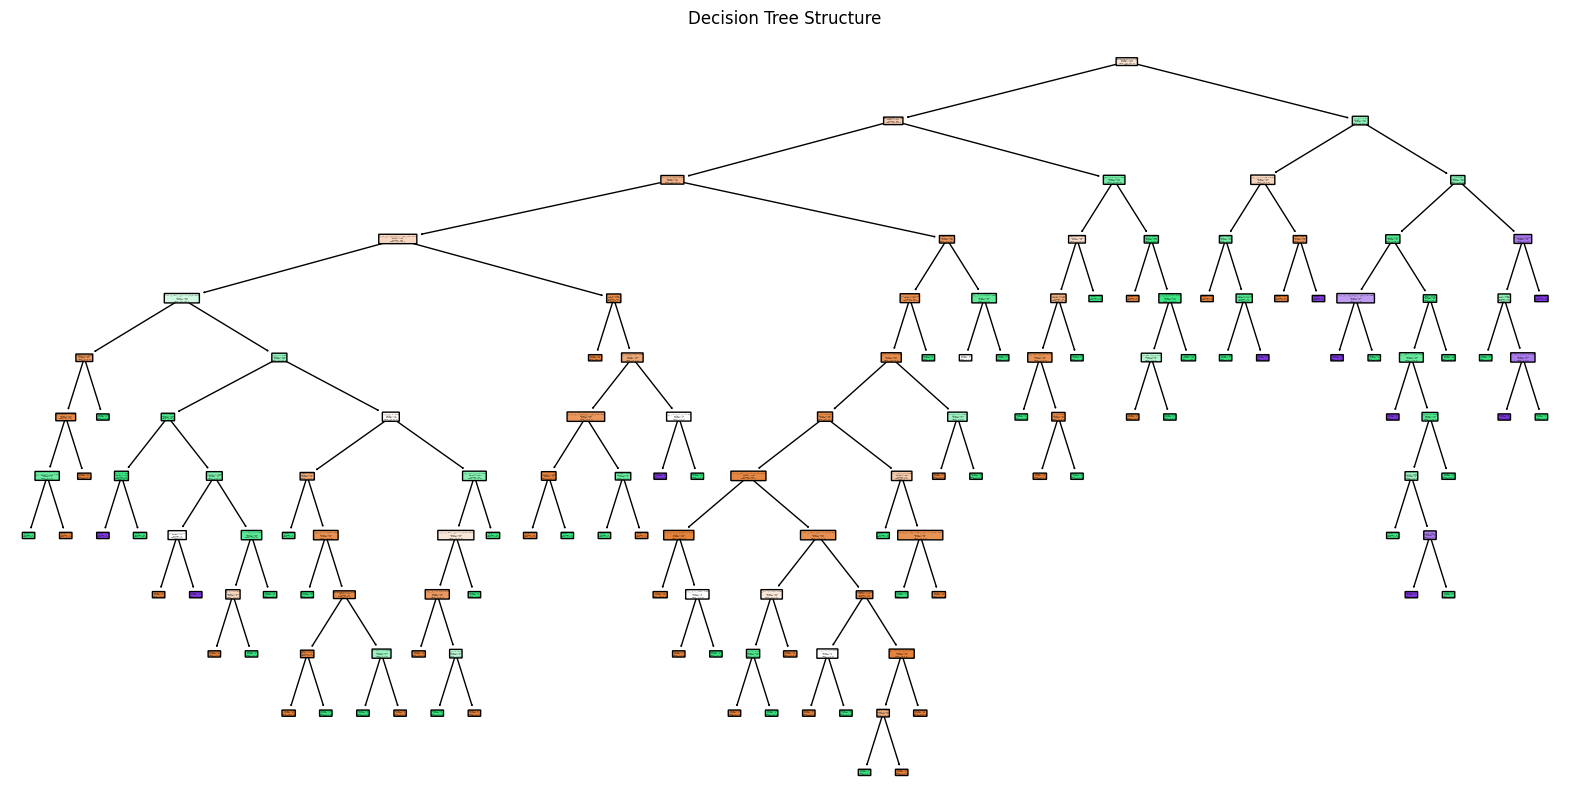

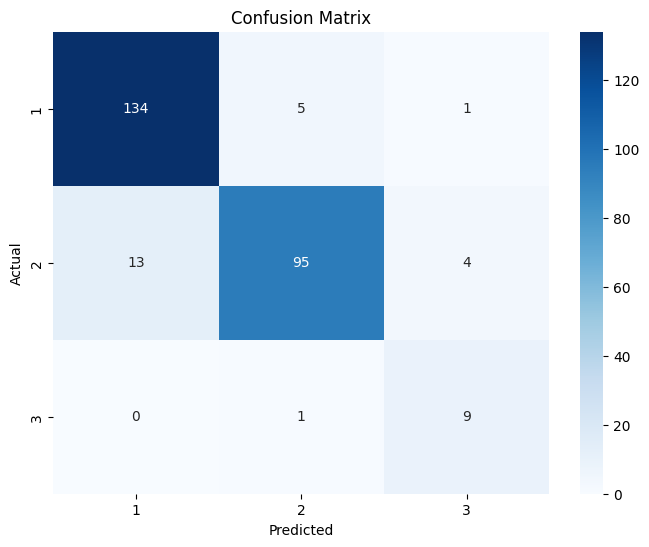

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(smote=SMOTE(random_state=42), random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a function for Bayesian Optimization
def dtree_evaluate(max_depth, min_samples_split, min_samples_leaf, criterion):
    criterion = 'gini' if criterion < 0.5 else 'entropy'
    model = DecisionTreeClassifier(
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        criterion=criterion,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='weighted')

# Set the parameter bounds for Bayesian Optimization
param_bounds = {
    'max_depth': (5, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'criterion': (0, 1)  # This will be used to choose between 'gini' and 'entropy'
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=dtree_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

# Perform the optimization
optimizer.maximize(init_points=10, n_iter=50)

# Extract the best parameters and retrain the model
best_params = optimizer.max['params']
best_params['criterion'] = 'gini' if best_params['criterion'] < 0.5 else 'entropy'
best_tree = DecisionTreeClassifier(
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    criterion=best_params['criterion'],
    random_state=42
)
best_tree.fit(X_train, y_train)

# Predict the test set results
y_pred = best_tree.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=df.drop(columns=["Unified Liver Grade"]).columns, class_names=np.unique(y).astype(str), filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.show()

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### with Decision Tree (with Deap Optimized hyper-parameters) and SMOTE and Undersampling of the majority class

**Genetic Algorithms:** These algorithms simulate the process of natural selection to find the best hyperparameters for our model. They are particularly useful for exploring large, complex spaces where traditional grid search may be inefficient.

**Evolutionary Process:** The algorithm iteratively improves the population of solutions by selecting, mating, and mutating individuals based on their fitness.


**Genetic Algorithm Setup:**

1.  Fitness Function (evaluate_individual): Evaluates the Decision Tree model's performance (F1 Score) given a set of hyperparameters.
2.  Individual Representation: Each individual represents a set of hyperparameters (max depth, min samples split, min samples leaf, and criterion).
3.  Genetic Operators: Includes crossover (tools.cxTwoPoint), mutation (tools.mutFlipBit), and selection (tools.selTournament).

**Run the Genetic Algorithm:**

Generations and Population: The algorithm runs for a set number of generations, evolving the population of individuals to find the best hyperparameters.

**Best Model Training:**

After the genetic algorithm finishes, the best individual is used to train the final Decision Tree model.

**Sometimes it finds better parameters, but in our case it did not!**

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best individual in generation 0: [19, 3, 1, 0.8079936028128215], F1 Score: 0.9089229412345731
Best individual in generation 1: [19, 3, 1, 0.8079936028128215], F1 Score: 0.9089229412345731
Best individual in generation 2: [16, 3, 1, 0.6987214443200578], F1 Score: 0.9089229412345731
Best individual in generation 3: [16, 3, 1, 0.6987214443200578], F1 Score: 0.9089229412345731
Best individual in generation 4: [19, 3, 1, 0.8434313147520759], F1 Score: 0.9089229412345731
Best individual in generation 5: [13, 2, 1, 0.6987214443200578], F1 Score: 0.9089229412345731
Best individual in generation 6: [16, 2, 1, 0.6987214443200578], F1 Score: 0.9089229412345731
Best individual in generation 7: [13, 2, 1, 0.6987214443200578], F1 Score: 0.9089229412345731
Best individual in generation 8: [17, 3, 1, 0.6987214443200578], F1 Score: 0.9089229412345731
Best individual in generation 9: [16, 2, 1, 0.6987214443200578], F1 Score: 0.9089229412345731
Best individual in generation 10: [13, 2, 1, 0.8434313147520

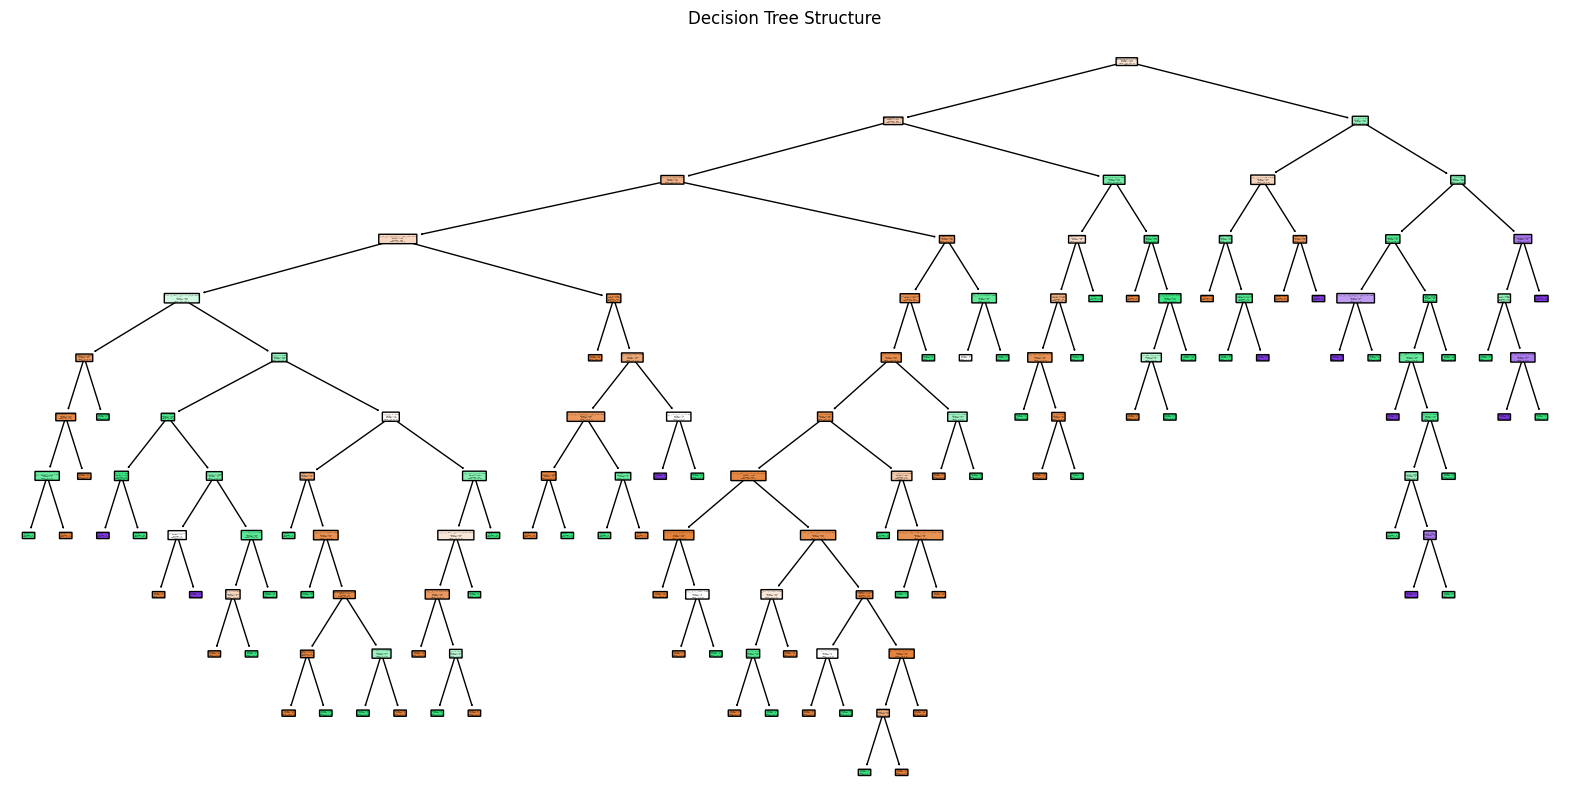

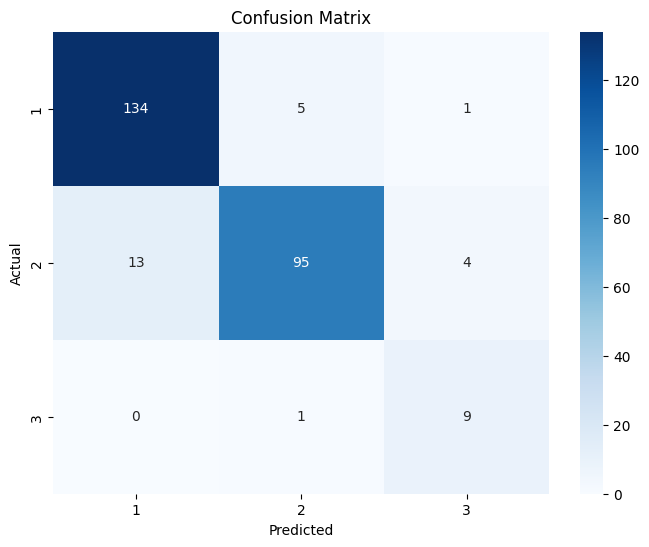

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from deap import base, creator, tools, algorithms
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(smote=SMOTE(random_state=42), random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the fitness function for Genetic Algorithm
def evaluate_individual(individual):
    max_depth, min_samples_split, min_samples_leaf, criterion = individual
    criterion = 'gini' if criterion < 0.5 else 'entropy'
    model = DecisionTreeClassifier(
        max_depth=max(1, int(max_depth)),  # Ensure max_depth is at least 1
        min_samples_split=max(2, int(min_samples_split)),  # Ensure min_samples_split is at least 2
        min_samples_leaf=max(1, int(min_samples_leaf)),  # Ensure min_samples_leaf is at least 1
        criterion=criterion,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='weighted'),

# Set up Genetic Algorithm
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int_depth", random.randint, 1, 20)  # for max_depth, min 1
toolbox.register("attr_int_split", random.randint, 2, 10)  # for min_samples_split, min 2
toolbox.register("attr_int_leaf", random.randint, 1, 4)  # for min_samples_leaf, min 1
toolbox.register("attr_criterion", random.random)  # for criterion

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int_depth, toolbox.attr_int_split, toolbox.attr_int_leaf, toolbox.attr_criterion), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=50)
NGEN = 20
CXPB = 0.7
MUTPB = 0.2

# Run Genetic Algorithm
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = map(toolbox.evaluate, offspring)

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))
    top_individual = tools.selBest(population, k=1)[0]
    print(f"Best individual in generation {gen}: {top_individual}, F1 Score: {top_individual.fitness.values[0]}")

# Train the best model with the best hyperparameters
best_params = top_individual
criterion = 'gini' if best_params[3] < 0.5 else 'entropy'
best_tree = DecisionTreeClassifier(
    max_depth=max(1, int(best_params[0])),  # Ensure max_depth is at least 1
    min_samples_split=max(2, int(best_params[1])),  # Ensure min_samples_split is at least 2
    min_samples_leaf=max(1, int(best_params[2])),  # Ensure min_samples_leaf is at least 1
    criterion=criterion,
    random_state=42
)
best_tree.fit(X_train, y_train)

# Predict the test set results
y_pred = best_tree.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Parameters:", best_params)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=df.drop(columns=["Unified Liver Grade"]).columns, class_names=np.unique(y).astype(str), filled=True, rounded=True)
plt.title('Decision Tree Structure')
plt.show()

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### 2. Random Forest

### with Random Forest and GridSearchCV

Best Hyperparameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Cross-Validation F1 Score: 0.5946238840477271
Accuracy: 0.6513761467889908
Precision: 0.6158435857818467
Recall: 0.6513761467889908
F1 Score: 0.6215183009806867

Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.06      0.11        16
           2       0.49      0.39      0.44        66
           3       0.71      0.85      0.77       136

    accuracy                           0.65       218
   macro avg       0.51      0.43      0.44       218
weighted avg       0.62      0.65      0.62       218

Confusion Matrix:
 [[  1   6   9]
 [  2  26  38]
 [  0  21 115]]


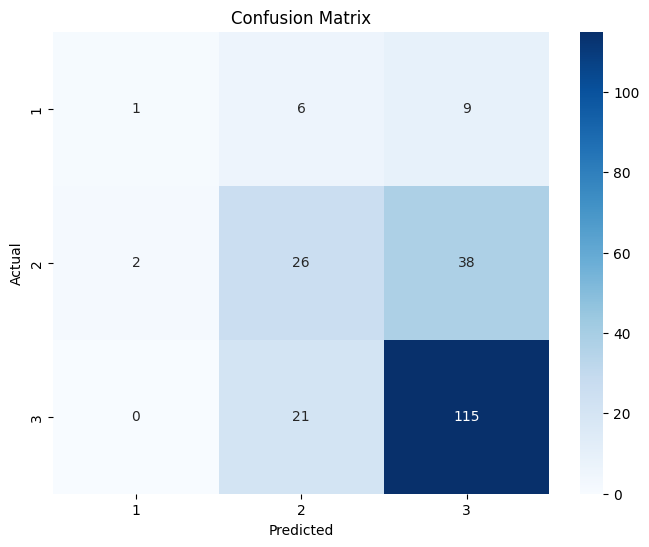

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier with hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Train the Random Forest classifier with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_rf.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### with Random Forest and SMOTE

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

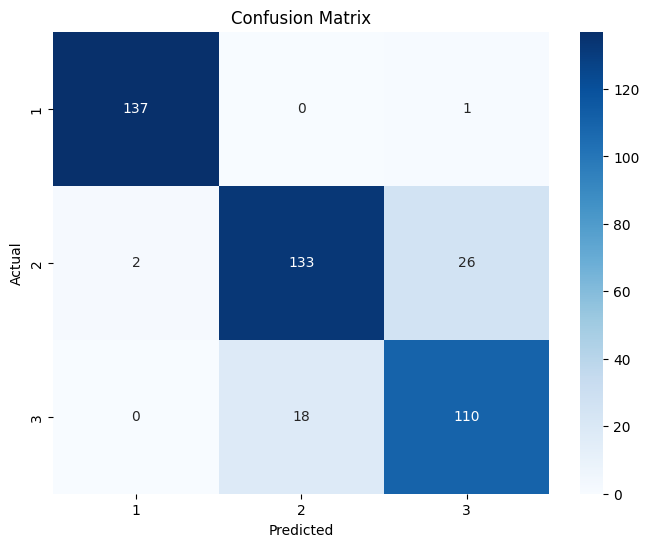

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a RandomForestClassifier with hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Train the Random Forest classifier with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_rf.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###with Random Forest and SMOTE and Undersampling of the majority class

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

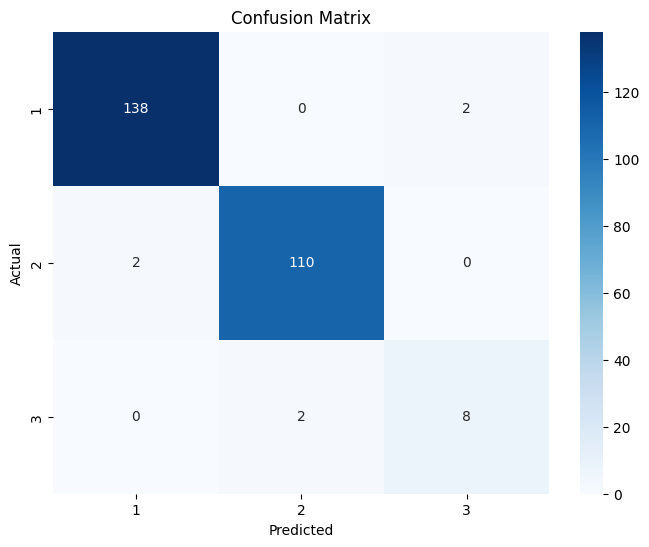

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(smote=SMOTE(random_state=42), random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train a RandomForestClassifier with hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Train the Random Forest classifier with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_rf.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###with Random Forest (with Bayesian Optimized hyper-parameters) and SMOTE and Undersampling of the majority class

Sometimes it finds better parameters, in this case the result did not change by much!

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

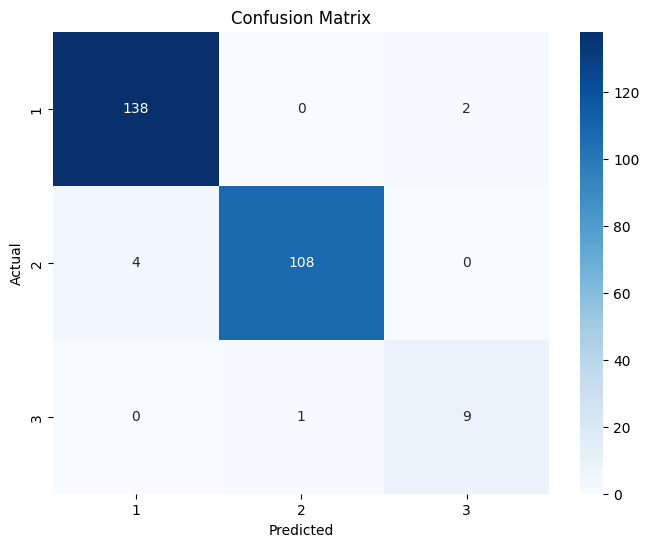

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTEENN
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(smote=SMOTE(random_state=42), random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the objective function for Bayesian Optimization
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap):
    n_estimators = int(n_estimators)
    max_depth = int(max_depth) if max_depth > 0 else None
    min_samples_split = int(min_samples_split)
    min_samples_leaf = int(min_samples_leaf)
    bootstrap = bool(round(bootstrap))

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_weighted')
    return scores.mean()

# Set up the parameter bounds for Bayesian Optimization
param_bounds = {
    'n_estimators': (50, 200),
    'max_depth': (5, 15),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'bootstrap': (0, 1)
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(f=rf_cv, pbounds=param_bounds, random_state=42, verbose=2)
optimizer.maximize(init_points=10, n_iter=50)

# Extract the best parameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth']) if best_params['max_depth'] > 0 else None
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])
best_params['bootstrap'] = bool(round(best_params['bootstrap']))

# Train the RandomForestClassifier with the best parameters
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_rf.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###with Random Forest (with Deap Optimized hyper-parameters) and SMOTE and Undersampling of the majority class

Best individual in generation 0: [46, 13, 3, 0, 0], F1 Score: 0.9515281620216841
Best individual in generation 1: [180, 13, 7, 1, 0], F1 Score: 0.9585587879812227
Best individual in generation 2: [180, 14, 7, 1, 0], F1 Score: 0.9586592359318746
Best individual in generation 3: [180, 14, 7, 1, 0], F1 Score: 0.9586592359318746
Best individual in generation 4: [180, 14, 7, 1, 0], F1 Score: 0.9586592359318746
Best individual in generation 5: [180, 14, 7, 1, 0], F1 Score: 0.9586592359318746
Best individual in generation 6: [180, 14, 7, 1, 0], F1 Score: 0.9586592359318746
Best individual in generation 7: [180, 14, 7, 1, 0], F1 Score: 0.9586592359318746
Best individual in generation 8: [180, 14, 0, 1, 0], F1 Score: 0.9604471925801107
Best individual in generation 9: [180, 14, 0, 1, 0], F1 Score: 0.9604471925801107
Best individual in generation 10: [180, 14, 0, 1, 0], F1 Score: 0.9604471925801107
Best individual in generation 11: [180, 14, 0, 1, 0], F1 Score: 0.9604471925801107
Best individual

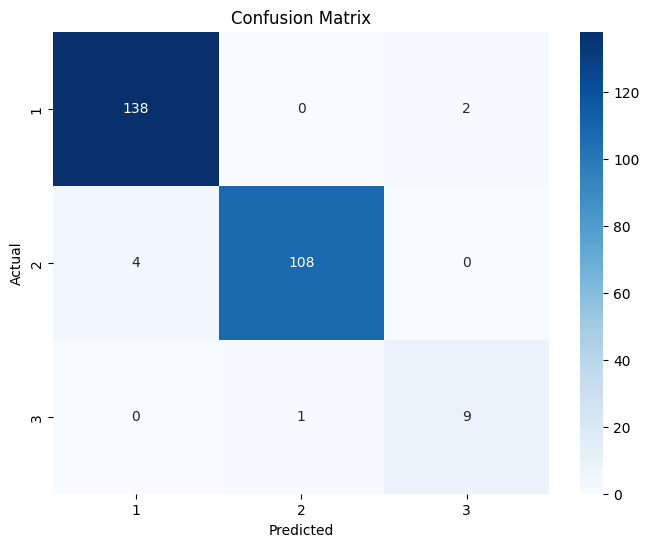

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTEENN
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# DEAP setup for Genetic Algorithm
def rf_evaluate(individual):
    n_estimators, max_depth, min_samples_split, min_samples_leaf, bootstrap = individual
    n_estimators = max(1, int(n_estimators))  # Ensure n_estimators is at least 1
    max_depth = max(1, int(max_depth))  # Ensure max_depth is at least 1
    min_samples_split = max(2, int(min_samples_split))  # Ensure min_samples_split is at least 2
    min_samples_leaf = max(1, int(min_samples_leaf))  # Ensure min_samples_leaf is at least 1
    bootstrap = bool(round(bootstrap))

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_weighted')
    return scores.mean(),

# DEAP parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 1, 200)  # n_estimators, ensuring min 1
toolbox.register("attr_int_depth", random.randint, 1, 15)  # max_depth, ensuring min 1
toolbox.register("attr_int_split", random.randint, 2, 10)  # min_samples_split, ensuring min 2
toolbox.register("attr_int_leaf", random.randint, 1, 4)  # min_samples_leaf, ensuring min 1
toolbox.register("attr_bool", random.randint, 0, 1)  # bootstrap (0 or 1)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_int_depth, toolbox.attr_int_split, toolbox.attr_int_leaf, toolbox.attr_bool), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", rf_evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=50)
NGEN = 20
CXPB = 0.7
MUTPB = 0.2

# Run Genetic Algorithm
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = map(toolbox.evaluate, offspring)

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))
    top_individual = tools.selBest(population, k=1)[0]
    print(f"Best individual in generation {gen}: {top_individual}, F1 Score: {top_individual.fitness.values[0]}")

# Extract the best parameters
best_params = top_individual
best_params_dict = {
    'n_estimators': max(1, int(best_params[0])),
    'max_depth': max(1, int(best_params[1])),
    'min_samples_split': max(2, int(best_params[2])),
    'min_samples_leaf': max(1, int(best_params[3])),
    'bootstrap': bool(round(best_params[4]))
}

# Train the RandomForestClassifier with the best parameters
best_rf = RandomForestClassifier(
    n_estimators=best_params_dict['n_estimators'],
    max_depth=best_params_dict['max_depth'],
    min_samples_split=best_params_dict['min_samples_split'],
    min_samples_leaf=best_params_dict['min_samples_leaf'],
    bootstrap=best_params_dict['bootstrap'],
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_rf, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_rf.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Parameters:", best_params_dict)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**GPT response to what might be the cause of SMOTEEN not improving the results with random forest:**

The significant difference in performance between SMOTE and SMOTEENN when using Random Forest as compared to Decision Tree can be attributed to several factors related to how these algorithms and sampling techniques interact with the data. Here's a breakdown of potential reasons:

1. Nature of the Algorithms:
Random Forest: Random Forest is an ensemble of decision trees. It inherently handles noise and overfitting better than a single decision tree by averaging the predictions of multiple trees. However, it can also be more sensitive to the specific distribution of the data.
Decision Tree: A single decision tree tends to overfit on imbalanced or noisy data, which might make it more amenable to corrections via techniques like SMOTEENN, which cleans the data by removing potentially noisy samples.
2. Effect of SMOTEENN on Data Distribution:
SMOTEENN: This technique combines oversampling (SMOTE) with undersampling (ENN). While it can effectively clean the data by removing noisy examples, it can also drastically change the data distribution, especially when applied to Random Forest, which relies on the bootstrapped sampling of data. The removal of certain samples might negatively impact the diversity and representativeness of the bootstrapped samples in Random Forest, leading to poor performance.
SMOTE: SMOTE only oversamples the minority class without removing any majority class samples. This maintains the overall diversity of the data, which may be better suited for Random Forest's bootstrapping approach.
3. Sensitivity to Data Imbalance:
Random Forest: Random Forest can sometimes handle imbalanced data better than a single decision tree due to its ensemble nature. However, when the data is overly modified by SMOTEENN, it may lose some of its inherent advantages, such as diversity in bootstrapping, leading to poorer performance.
Decision Tree: A single decision tree might struggle more with imbalanced data, making it more likely to benefit from the data cleaning aspect of SMOTEENN.
4. Hyperparameter Optimization:
The difference in results between SMOTE and SMOTEENN might also be influenced by how the hyperparameters were optimized. The hyperparameters that work well for SMOTE may not be ideal for SMOTEENN and vice versa. Even though both techniques were applied with optimized hyperparameters, the interaction between the hyperparameters and the resampling technique might differ, leading to the observed performance drop.
5. Overfitting Due to Data Reduction:
SMOTEENN: By removing samples, especially those close to decision boundaries, SMOTEENN might inadvertently reduce the dataset too much, leading to overfitting, particularly with complex models like Random Forest. This overfitting would explain the significantly lower accuracy and F1 scores.


Conclusion:
The poor performance of SMOTEENN with Random Forest in your case likely stems from how the Random Forest algorithm interacts with the data distribution after SMOTEENN is applied. This interaction seems to remove or alter data in ways that reduce the diversity needed for Random Forest to perform well, in contrast to a single Decision Tree that might benefit more from the data cleaning effects of SMOTEENN. Adjusting the resampling strategy, considering a hybrid approach, or optimizing hyperparameters specifically for SMOTEENN may help improve results.

###3. SVM

###with SVM

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

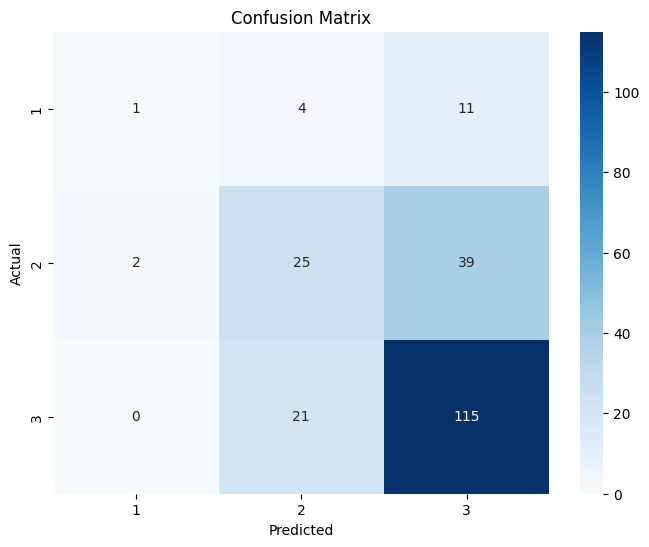

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()


# df.drop(columns=df.columns[57:-2])
# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize GridSearchCV with SVM
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Train the SVM with the best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_svm, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_svm.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###with SVM and SMOTE

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

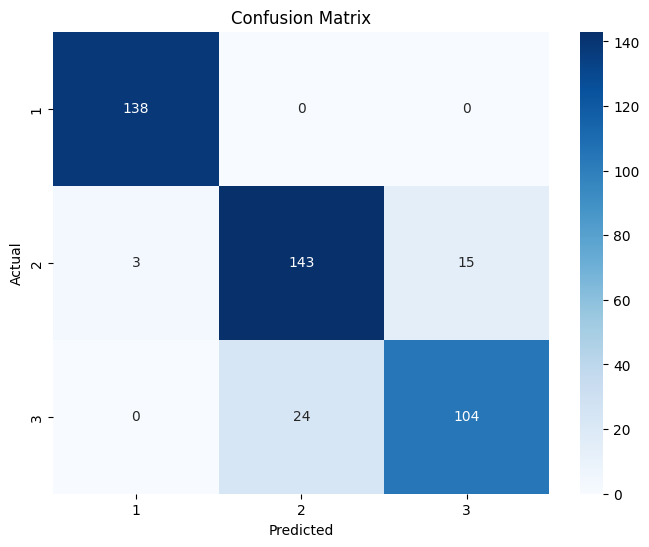

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize GridSearchCV with SVM
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Train the SVM with the best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_svm, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_svm.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###with SVM and SMOTE and Undersampling of the majority class

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

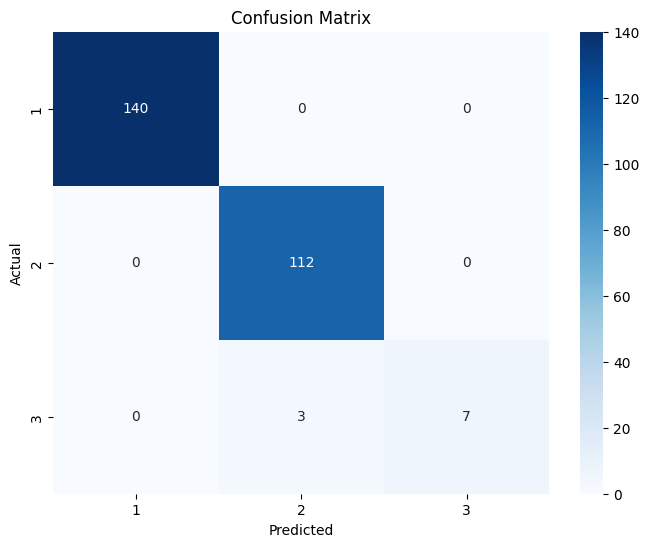

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(smote=SMOTE(random_state=42), random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize GridSearchCV with SVM
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted')
grid_search.fit(X_train, y_train)

# Train the SVM with the best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_svm, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_svm.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###with SVM (with Bayesian Optimized hyper-parameters) and SMOTE and Undersampling of the majority class

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

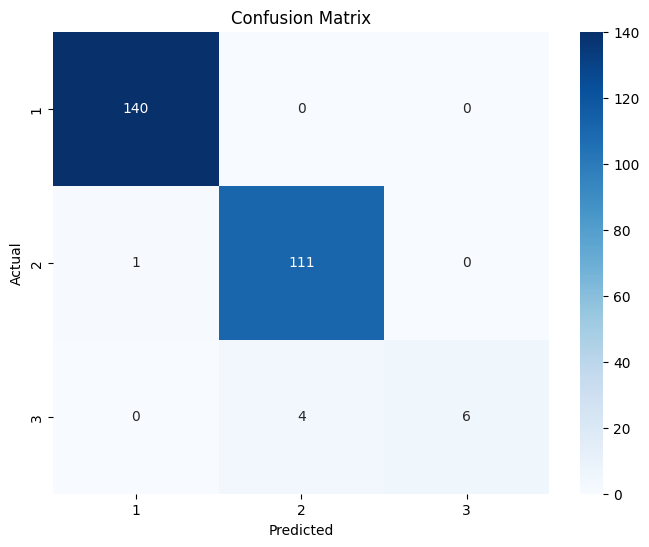

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from bayes_opt import BayesianOptimization

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(smote=SMOTE(random_state=42), random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the objective function for Bayesian Optimization
def svm_cv(C, gamma, kernel):
    C = max(0.1, C)
    gamma = max(0.0001, gamma)
    kernel = ['linear', 'rbf', 'poly'][int(kernel)]

    svm = SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)
    scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='f1_weighted')
    return scores.mean()

# Set up the parameter bounds for Bayesian Optimization
param_bounds = {
    'C': (0.1, 100),
    'gamma': (0.0001, 1),
    'kernel': (0, 2)  # Encodes kernel types: 0->'linear', 1->'rbf', 2->'poly'
}

# Run Bayesian Optimization
optimizer = BayesianOptimization(f=svm_cv, pbounds=param_bounds, random_state=42, verbose=2)
optimizer.maximize(init_points=10, n_iter=50)

# Extract the best parameters
best_params = optimizer.max['params']
best_params['C'] = max(0.1, best_params['C'])
best_params['gamma'] = max(0.0001, best_params['gamma'])
best_params['kernel'] = ['linear', 'rbf', 'poly'][int(best_params['kernel'])]

# Train the SVM with the best parameters
best_svm = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'], random_state=42)
best_svm.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_svm, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_svm.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

###with SVM (with DEAP Optimized hyper-parameters) and SMOTE and Undersampling of the majority class

Best individual in generation 0: [32.20799402534402, 0.22896110400706288, 2], F1 Score: 0.9551263269511278
Best individual in generation 1: [88.8191723602286, 0.21436652886440669, 2], F1 Score: 0.9551263269511278
Best individual in generation 2: [0.0, 0.04727111230401605, 2], F1 Score: 0.9551263269511278
Best individual in generation 3: [32.20799402534402, 0.9716484691902326, 2], F1 Score: 0.9551263269511278
Best individual in generation 4: [9.384643650899667, 0.8773092427538873, 2], F1 Score: 0.9551263269511278
Best individual in generation 5: [12.874890692769592, 0.2517858719191264, 2], F1 Score: 0.9551263269511278
Best individual in generation 6: [12.874890692769592, 0.7457272481041057, 2], F1 Score: 0.9551263269511278
Best individual in generation 7: [85.35666216277292, 0.2653823952757688, 2], F1 Score: 0.9551263269511278
Best individual in generation 8: [21.063840279880367, 0.7457272481041057, 2], F1 Score: 0.9551263269511278
Best individual in generation 9: [80.26814544503165, 0.

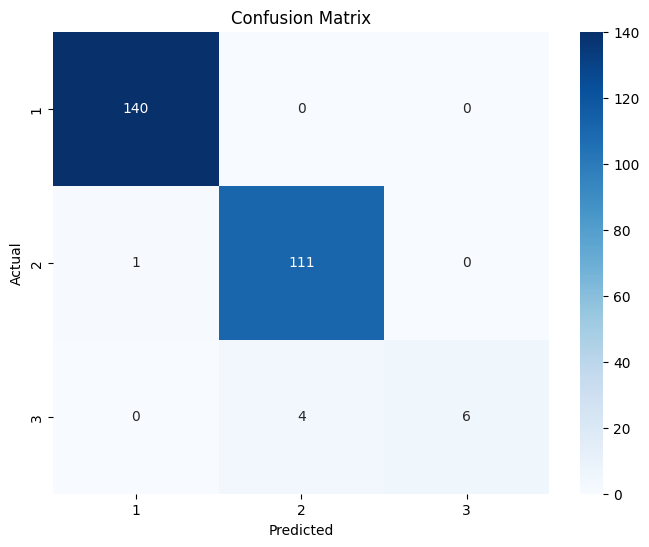

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTEENN
from deap import base, creator, tools, algorithms
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# DEAP setup for Genetic Algorithm
def svm_evaluate(individual):
    C, gamma, kernel = individual
    C = max(0.1, C)
    gamma = max(0.0001, gamma)
    kernel = ['linear', 'rbf', 'poly'][int(kernel)]

    svm = SVC(C=C, gamma=gamma, kernel=kernel, random_state=42)
    scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='f1_weighted')
    return scores.mean(),

# DEAP parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.1, 100)  # C
toolbox.register("attr_gamma", random.uniform, 0.0001, 1)  # gamma
toolbox.register("attr_int_kernel", random.randint, 0, 2)  # kernel type: 0->'linear', 1->'rbf', 2->'poly'

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_float, toolbox.attr_gamma, toolbox.attr_int_kernel), n=1)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", svm_evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=50)
NGEN = 20
CXPB = 0.7
MUTPB = 0.2

# Run Genetic Algorithm
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = map(toolbox.evaluate, offspring)

    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = toolbox.select(offspring, k=len(population))
    top_individual = tools.selBest(population, k=1)[0]
    print(f"Best individual in generation {gen}: {top_individual}, F1 Score: {top_individual.fitness.values[0]}")

# Extract the best parameters
best_params = top_individual
best_params_dict = {
    'C': max(0.1, best_params[0]),
    'gamma': max(0.0001, best_params[1]),
    'kernel': ['linear', 'rbf', 'poly'][int(best_params[2])]
}

# Train the SVM with the best parameters
best_svm = SVC(C=best_params_dict['C'], gamma=best_params_dict['gamma'], kernel=best_params_dict['kernel'], random_state=42)
best_svm.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_svm, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_svm.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Parameters:", best_params_dict)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###4. LogisticRegression

###with LogisticRegression

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

Best Hyperparameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Cross-Validation F1 Score: 0.623388044472328
Accuracy: 0.6422018348623854
Precision: 0.5756830902061991
Recall: 0.6422018348623854
F1 Score: 0.6029622431434704

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        16
           2       0.45      0.36      0.40        66
           3       0.70      0.85      0.77       136

    accuracy                           0.64       218
   macro avg       0.39      0.41      0.39       218
weighted avg       0.58      0.64      0.60       218

Confusion Matrix:
 [[  0   9   7]
 [  0  24  42]
 [  0  20 116]]


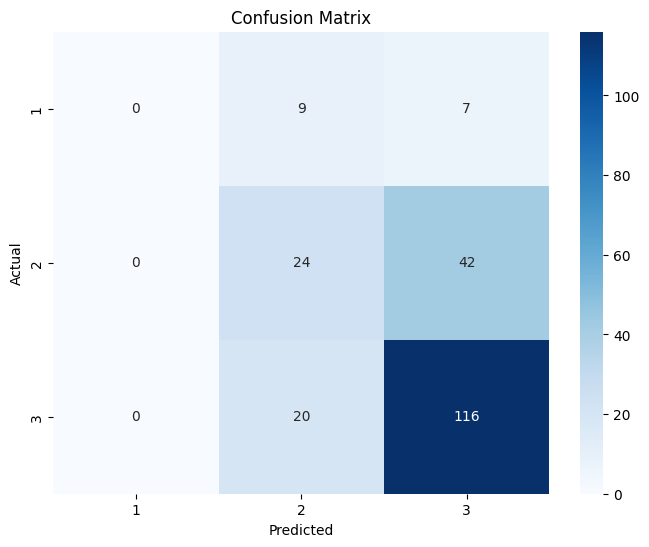

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates and some with high missing values
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Handle missing values
# Fill numeric columns with median
for column in df.select_dtypes(include=['number']).columns:
    df[column].fillna(df[column].median(), inplace=True)

# For object type columns, fill missing with mode
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a parameter grid for Logistic Regression with compatible solver and penalty pairs
param_grid = [
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'max_iter': [100, 200, 300]},
    {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 300]},
    {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'max_iter': [100, 200, 300], 'l1_ratio': [0.5]} # l1_ratio for elasticnet
]

# Initialize GridSearchCV with Logistic Regression
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted', error_score='raise')
grid_search.fit(X_train, y_train)

# Train the Logistic Regression with the best parameters
best_lr = grid_search.best_estimator_
best_lr.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_lr, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_lr.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

###with LogisticRegression and SMOTE

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Hyperparameters: {'C': 100, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-Validation F1 Score: 0.5752220285722688
Accuracy: 0.7236533957845434
Precision: 0.7221541468826482
Recall: 0.7236533957845434
F1 Score: 0.7156599544598619

Classification Report:
               precision    recall  f1-score   support

           1       0.80      0.98      0.88       138
           2       0.75      0.58      0.65       161
           3       0.60      0.63      0.62       128

    accuracy                           0.72       427
   macro avg       0.72      0.73      0.72       427
weighted avg       0.72      0.72      0.72       427

Confusion Matrix:
 [[135   1   2]
 [ 17  93  51]
 [ 17  30  81]]


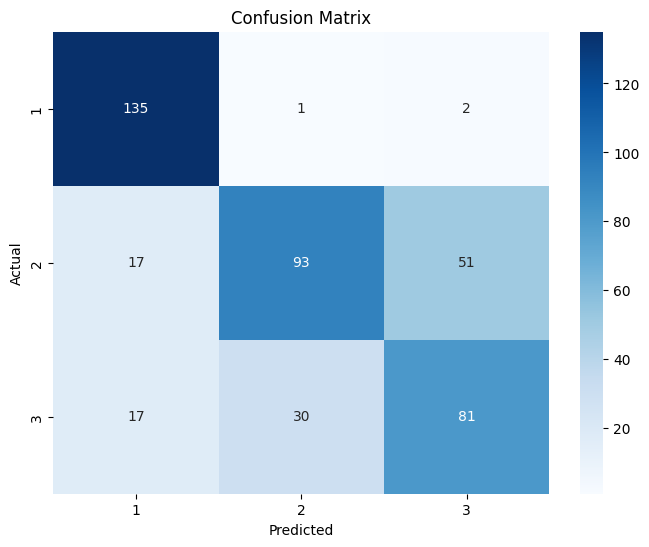

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a parameter grid for Logistic Regression with compatible solver and penalty pairs
param_grid = [
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'max_iter': [100, 200, 300]},
    {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 300]},
    {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'max_iter': [100, 200, 300], 'l1_ratio': [0.5]} # l1_ratio for elasticnet
]

# Initialize GridSearchCV with Logistic Regression
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted', error_score='raise')
grid_search.fit(X_train, y_train)

# Train the Logistic Regression with the best parameters
best_lr = grid_search.best_estimator_
best_lr.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_lr, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_lr.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

###with LogisticRegression and SMOTE and Undersampling of the majority class

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Best Hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-Validation F1 Score: 0.5728958376782725
Accuracy: 0.9580152671755725
Precision: 0.9577982687688759
Recall: 0.9580152671755725
F1 Score: 0.9570136368518344

Classification Report:
               precision    recall  f1-score   support

           1       0.95      1.00      0.98       140
           2       0.97      0.93      0.95       112
           3       0.88      0.70      0.78        10

    accuracy                           0.96       262
   macro avg       0.93      0.88      0.90       262
weighted avg       0.96      0.96      0.96       262

Confusion Matrix:
 [[140   0   0]
 [  7 104   1]
 [  0   3   7]]


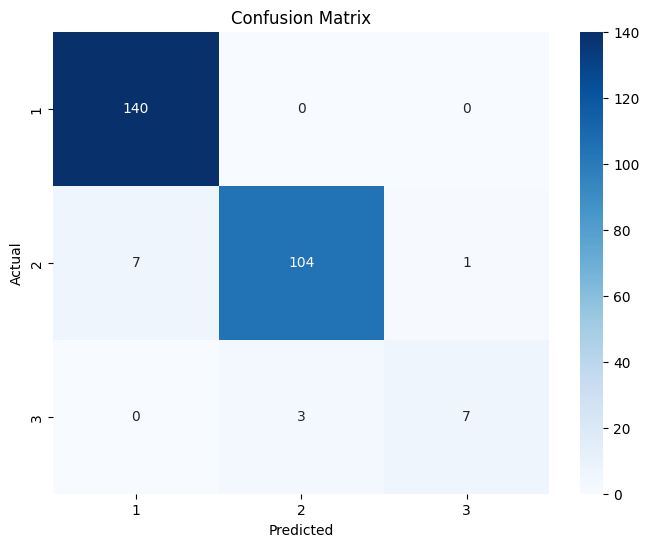

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a parameter grid for Logistic Regression with compatible solver and penalty pairs
param_grid = [
    {'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs'], 'max_iter': [100, 200, 300]},
    {'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [100, 200, 300]},
    {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.01, 0.1, 1, 10, 100], 'solver': ['saga'], 'max_iter': [100, 200, 300], 'l1_ratio': [0.5]} # l1_ratio for elasticnet
]

# Initialize GridSearchCV with Logistic Regression
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='f1_weighted', error_score='raise')
grid_search.fit(X_train, y_train)

# Train the Logistic Regression with the best parameters
best_lr = grid_search.best_estimator_
best_lr.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_lr, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_lr.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

###with LogisticRegression (with Bayesian Optimized hyper-parameters)  and SMOTE and Undersampling of the majority class

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

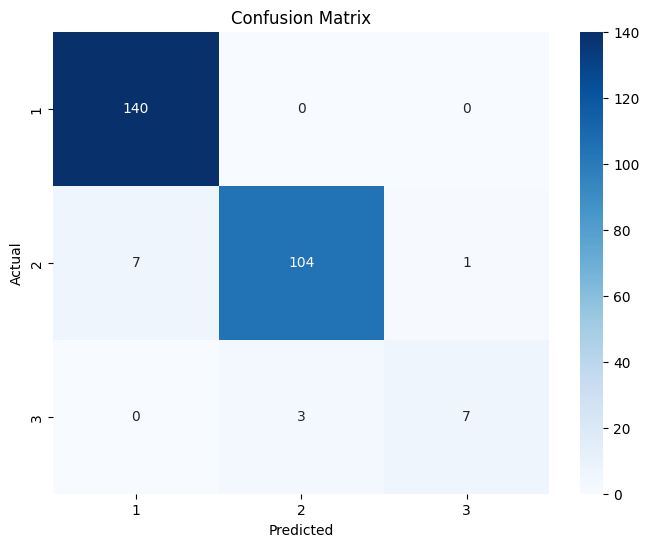

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from bayes_opt import BayesianOptimization

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(
    columns=[
        'تاریخ تکمیل پرسشنامه',
        'تاریخ',
        'Abd. Sonography Date',
        'Liver Fibroscan Date',
        'Liver Biopsy Date',
        'HCV ab Date',
        'Insulin Level',
        'شهر محل سکونت',
    ],
    inplace=True,
)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Map categorical parameters to integers
penalty_options = {0: 'l1', 1: 'l2', 2: 'elasticnet', 3: 'none'}
solver_options = {0: 'liblinear', 1: 'lbfgs', 2: 'saga'}

# Define the function to optimize
def lr_cv(C, max_iter, penalty, solver, l1_ratio):
    # Map penalty and solver
    penalty_options = {0: 'l1', 1: 'l2', 2: 'elasticnet', 3: 'none'}
    solver_options = {0: 'liblinear', 1: 'lbfgs', 2: 'saga'}

    penalty = penalty_options[int(round(penalty))]
    solver = solver_options[int(round(solver))]
    C = float(C)
    max_iter = int(round(max_iter))
    l1_ratio = float(l1_ratio)

    # Check if combination is valid
    valid_combination = True
    if penalty == 'elasticnet' and solver != 'saga':
        valid_combination = False
    if penalty == 'l1' and solver not in ['liblinear', 'saga']:
        valid_combination = False
    if penalty == 'l2' and solver not in ['liblinear', 'lbfgs', 'sag', 'saga']:
        valid_combination = False
    if penalty == 'none' and solver not in ['lbfgs', 'sag', 'saga']:
        valid_combination = False
    if solver == 'liblinear' and penalty == 'none':
        valid_combination = False
    if penalty == 'l1' and solver == 'lbfgs':
        valid_combination = False
    if solver == 'lbfgs' and penalty == 'l1':
        valid_combination = False

    if not valid_combination:
        return 0

    # Create LogisticRegression model
    try:
        model = LogisticRegression(
            C=C,
            penalty=penalty,
            solver=solver,
            max_iter=max_iter,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else None,
            random_state=42,
            n_jobs=-1,
        )
        # Cross-validation score
        scores = cross_val_score(
            model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1
        )
        return scores.mean()
    except Exception as e:
        return 0

# Define the parameter bounds
pbounds = {
    'C': (0.001, 1000),
    'max_iter': (100, 500),
    'penalty': (0, 3),  # integers 0 to 3
    'solver': (0, 2),   # integers 0 to 2
    'l1_ratio': (0.0, 1.0),
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=lr_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2,
)

# Run the optimizer
optimizer.maximize(
    init_points=10,
    n_iter=30,
)

# Extract the best parameters
best_params = optimizer.max['params']

# Map back the integer parameters to their categorical values
best_penalty = penalty_options[int(round(best_params['penalty']))]
best_solver = solver_options[int(round(best_params['solver']))]
best_C = best_params['C']
best_max_iter = int(round(best_params['max_iter']))
best_l1_ratio = best_params['l1_ratio'] if best_penalty == 'elasticnet' else None

# Train the Logistic Regression with the best parameters
best_lr = LogisticRegression(
    C=best_C,
    penalty=best_penalty,
    solver=best_solver,
    max_iter=best_max_iter,
    l1_ratio=best_l1_ratio,
    random_state=42,
    n_jobs=-1,
)
best_lr.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(
    best_lr, X_scaled, y, cv=5, scoring='f1_weighted', n_jobs=-1
)

# Predict the test set results
y_pred = best_lr.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Generate a classification report and confusion matrix
classification_rep = classification_report(
    y_test, y_pred, zero_division=0
)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:")
print(f"Penalty: {best_penalty}")
print(f"Solver: {best_solver}")
print(f"C: {best_C}")
print(f"Max Iterations: {best_max_iter}")
if best_penalty == 'elasticnet':
    print(f"L1 Ratio: {best_l1_ratio}")
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=np.unique(y),
    yticklabels=np.unique(y),
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###with LogisticRegression (with DEAP Optimized hyper-parameters) and SMOTE and Undersampling of the majority class

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn

gen	nevals
0  	50    


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

1  	25    


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

2  	33    


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

3  	26    


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

4  	28    


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

5  	30    


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

6  	27    
7  	27    
8  	28    
9  	27    
10 	29    


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

11 	26    
12 	31    


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

13 	34    
14 	29    
15 	23    
16 	24    
17 	30    


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

18 	37    
19 	34    
20 	30    
Best Hyperparameters (C, max_iter): [0.8571300422317315, 98.05364384697685]
Accuracy: 0.9580152671755725
Precision: 0.9577982687688759
Recall: 0.9580152671755725
F1 Score: 0.9570136368518344

Classification Report:
               precision    recall  f1-score   support

           1       0.95      1.00      0.98       140
           2       0.97      0.93      0.95       112
           3       0.88      0.70      0.78        10

    accuracy                           0.96       262
   macro avg       0.93      0.88      0.90       262
weighted avg       0.96      0.96      0.96       262

Confusion Matrix:
 [[140   0   0]
 [  7 104   1]
 [  0   3   7]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


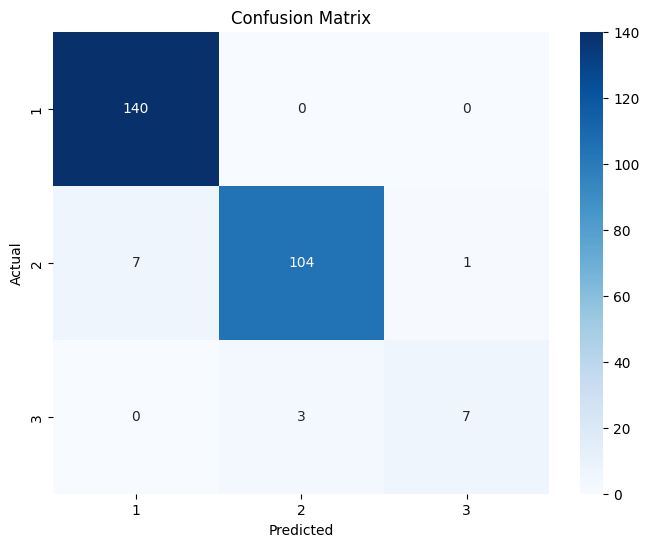

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from deap import base, creator, tools, algorithms
import random

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check and handle missing values
for column in df.select_dtypes(include=['number']).columns:
    df[column].fillna(df[column].median(), inplace=True)
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Set up DEAP genetic algorithm components
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define the hyperparameter search space
def create_individual():
    # C (regularization) will be on a log scale (0.001 to 1000), max_iter will be between 100 and 1000
    return [random.uniform(-3, 3), random.randint(100, 1000)]

# Evaluate the F1 score of a given Logistic Regression model
def evaluate(individual):
    C = 10 ** individual[0]  # Convert from log scale
    max_iter = int(individual[1])  # Ensure max_iter is an integer
    model = LogisticRegression(C=C, solver='lbfgs', max_iter=max_iter, random_state=42)
    try:
        cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted').mean()
    except Exception as e:
        return -1.0,  # Return a very low score for invalid configurations
    return cv_score,

# Register the necessary components for the genetic algorithm
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover (blend crossover)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)  # Mutation (Gaussian)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Create an initial population
population = toolbox.population(n=50)

# Apply the genetic algorithm to find the best set of hyperparameters
n_generations = 20
hof = tools.HallOfFame(1)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations,
                    stats=None, halloffame=hof, verbose=True)

# Extract the best individual (hyperparameters)
best_individual = hof[0]
best_C = 10 ** best_individual[0]
best_max_iter = int(best_individual[1])

# Train the Logistic Regression model with the best parameters
best_lr = LogisticRegression(C=best_C, solver='lbfgs', max_iter=best_max_iter, random_state=42)
best_lr.fit(X_train, y_train)

# Predict the test set results
y_pred = best_lr.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters (C, max_iter):", best_individual)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###5. XGBoost

###with XGBoost

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 10, 'subsample': 0.8}
Cross-Validation F1 Score: 0.622047440100663
Accuracy: 0.6743119266055045
Precision: 0.6216387839539484
Recall: 0.6743119266055045
F1 Score: 0.6467664883384451

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.51      0.53      0.52        66
           2       0.75      0.82      0.78       136

    accuracy                           0.67       218
   macro avg       0.42      0.45      0.44       218
weighted avg       0.62      0.67      0.65       218

Confusion Matrix:
 [[  0   9   7]
 [  0  35  31]
 [  0  24 112]]


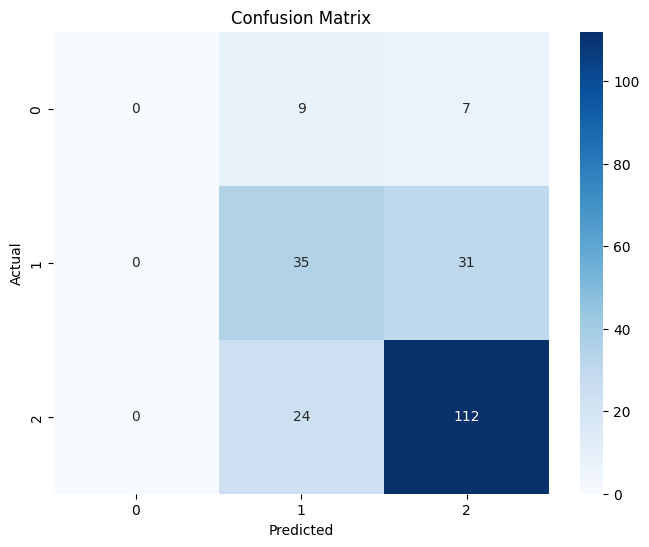

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates and some with high missing values
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Handle missing values
# Fill numeric columns with median
for column in df.select_dtypes(include=['number']).columns:
    df[column].fillna(df[column].median(), inplace=True)

# For object type columns, fill missing with mode
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"] - 1  # Adjust labels to be zero-indexed

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1, 10]
}

# Initialize GridSearchCV with XGBoost
grid_search = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
                           param_grid, cv=5, n_jobs=-1, scoring='f1_weighted', error_score='raise')
grid_search.fit(X_train, y_train)

# Train the XGBoost with the best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_xgb, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_xgb.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###with XGBoost and SMOTE

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

/tmp/ipykernel_2060/1077222195.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)
/tmp/ipykernel_2060/1077222195.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}
Cross-Validation F1 Score: 0.5598963078021378
Accuracy: 0.8711943793911007
Precision: 0.8761121935112842
Recall: 0.8711943793911007
F1 Score: 0.8721358461907068

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       138
           1       0.88      0.81      0.84       161
           2       0.76      0.86      0.81       128

    accuracy                           0.87       427
   macro avg       0.87      0.87      0.87       427
weighted avg       0.88      0.87      0.87       427

Confusion Matrix:
 [[132   0   6]
 [  3 130  28]
 [  1  17 110]]


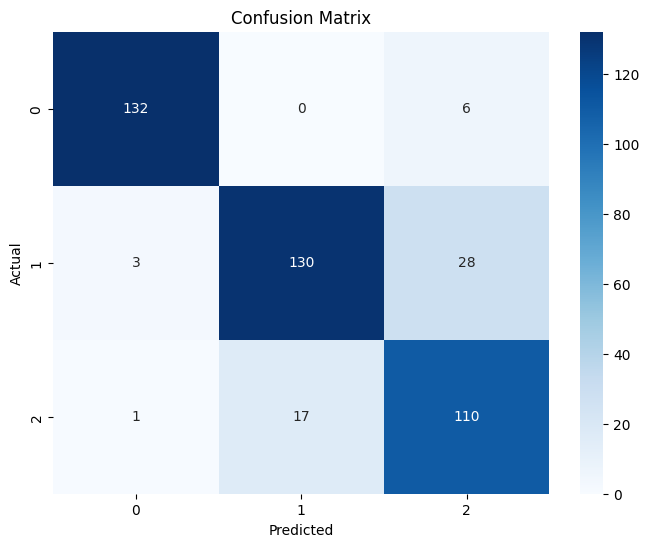

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE

# Load the final cleaned dataset
file_path = './cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"] - 1  # Adjust labels to be zero-indexed

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1, 10]
}

# Initialize GridSearchCV with XGBoost
grid_search = GridSearchCV(XGBClassifier(random_state=42, eval_metric='mlogloss'),
                           param_grid, cv=5, n_jobs=-1, scoring='f1_weighted', error_score='raise')
grid_search.fit(X_train, y_train)

# Train the XGBoost with the best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_xgb, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_xgb.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


###with XGBoost and SMOTE and Undersampling of majority class

Initial missing values in each column:
HCV ab                     0
FBS                      492
HB A1C                   962
Triglyceride             503
Cholesterol              508
                        ... 
Fibroscan Score            0
Liver Biopsy               0
Liver Biopsy Path NO.      0
Liver Biopsy Result        0
Unified Liver Grade        0
Length: 141, dtype: int64
Filling missing values in FBS with median: 99.0
Filling missing values in HB A1C with median: 6.0
Filling missing values in Triglyceride with median: 160.5
Filling missing values in Cholesterol with median: 181.0
Filling missing values in HDL with median: 42.0
Filling missing values in LDL with median: 104.0
Filling missing values in TSH with median: 2.43
Filling missing values in قد with median: 165.0
Filling missing values in وزن with median: 81.0
Filling missing values in BMI with median: 29.40292024457884
Filling missing values in دور کمر with median: 102.0
Filling missing values in دور ران with median: 5

/tmp/ipykernel_6626/1067281210.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)
/tmp/ipykernel_6626/1067281210.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.6}
Cross-Validation F1 Score: 0.5688018784058694
Accuracy: 0.9770992366412213
Precision: 0.9770992366412213
Recall: 0.9770992366412213
F1 Score: 0.9770992366412213

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       140
           1       0.98      0.98      0.98       112
           2       0.80      0.80      0.80        10

    accuracy                           0.98       262
   macro avg       0.92      0.92      0.92       262
weighted avg       0.98      0.98      0.98       262

Confusion Matrix:
 [[138   0   2]
 [  2 110   0]
 [  0   2   8]]


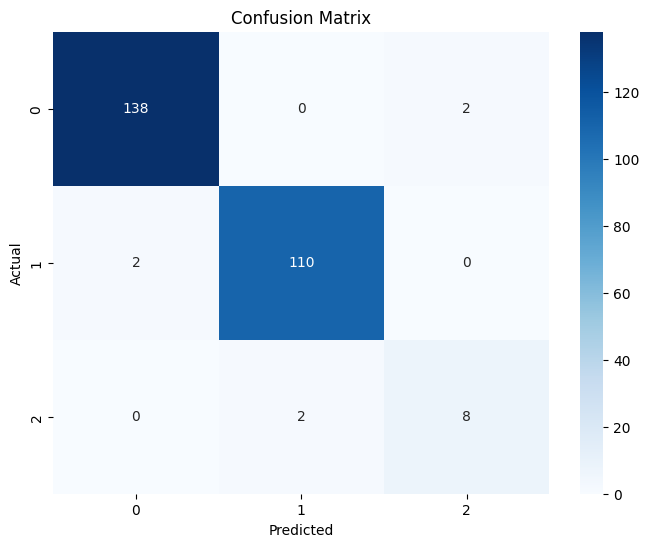

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

# Load the final cleaned dataset
file_path = './cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Check for missing values
print("Initial missing values in each column:")
print(df.isnull().sum())

# Handle missing values for numeric columns using median
for column in df.select_dtypes(include=['number']).columns:
    if df[column].isnull().sum() > 0:
        median_value = df[column].median()
        print(f"Filling missing values in {column} with median: {median_value}")
        df[column].fillna(median_value, inplace=True)

# Handle missing values for categorical columns using mode
for column in df.select_dtypes(include=['object']).columns:
    if df[column].isnull().sum() > 0:
        mode_value = df[column].mode()[0]
        print(f"Filling missing values in {column} with mode: {mode_value}")
        df[column].fillna(mode_value, inplace=True)

# Check again for any remaining missing values
missing_values_after_filling = df.isnull().sum()
print("\nMissing values in each column after filling:")
print(missing_values_after_filling)

# Ensure no missing values remain before proceeding
if missing_values_after_filling.sum() > 0:
    raise ValueError("There are still missing values in the dataset!")

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"] - 1  # Adjust labels to be zero-indexed

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define a parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.1, 1, 10]
}

# Initialize GridSearchCV with XGBoost
grid_search = GridSearchCV(XGBClassifier(random_state=42, eval_metric='mlogloss'),
                           param_grid, cv=5, n_jobs=-1, scoring='f1_weighted', error_score='raise')
grid_search.fit(X_train, y_train)

# Train the XGBoost with the best parameters
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_xgb, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_xgb.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### XGBoost (with Bayesian Optimized hyper-parameters) and SMOTE and Undersampling of majority class

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9425    | 0.7498    | 0.1901    | 0.1491    | 5.395     | 73.4      | 0.078     | 0.675     | 0.9465    |
| 2         | 0.9188    | 0.8404    | 0.1416    | 0.01391   | 6.88      | 174.9     | 0.1062    | 1.9       | 0.6734    |
| 3         | 0.9475    | 0.7217    | 0.105     | 0.09207   | 4.165     | 141.8     | 0.06975   | 2.992     | 0.7465    |
| 4         | 0.9358    | 0.7824    | 0.157     | 0.04794   | 5.057     | 138.9     | 0.02323   | 6.115     | 0.6682    |
| 5         | 0.9468    | 0.626     | 0.1898    | 0.1935    | 6.234     | 95.69     | 0.04884   | 6.874     | 0.7761    |
| 6         | 0.947     | 0.8013    | 0.1593    | 0.1505    | 5.582     | 73.37     | 0.2735    | 0.9657    | 0.7509    |
| 7         | 0.9553    

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [08:09:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.010405700651768006, 'learning_rate': 0.15585248268123061, 'max_depth': 6.482965976089807, 'n_estimators': 73.1825984967411, 'reg_alpha': 0.5, 'reg_lambda': 2.3762318805845313, 'subsample': 0.6}
Cross-Validation F1 Score: 0.5631932366324858
Accuracy: 0.9694656488549618
Precision: 0.9695418869916236
Recall: 0.9694656488549618
F1 Score: 0.9694437006439607

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       140
           1       0.98      0.96      0.97       112
           2       0.80      0.80      0.80        10

    accuracy                           0.97       262
   macro avg       0.92      0.92      0.92       262
weighted avg       0.97      0.97      0.97       262

Confusion Matrix:
 [[138   0   2]
 [  4 108   0]
 [  0   2   8]]


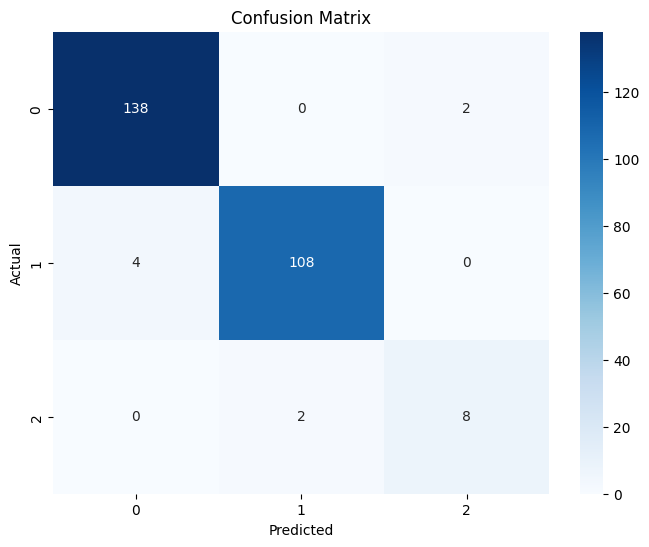

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from bayes_opt import BayesianOptimization

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Handle missing values
for column in df.select_dtypes(include=['number']).columns:
    df[column].fillna(df[column].median(), inplace=True)
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"] - 1  # Adjust labels to be zero-indexed

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the function to optimize
def xgb_evaluate(n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda):
    model = XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        eval_metric='mlogloss'
    )
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted').mean()
    return cv_score

# Set parameter bounds for Bayesian Optimization
params = {
    'n_estimators': (50, 200),
    'max_depth': (3, 7),
    'learning_rate': (0.01, 0.2),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'gamma': (0, 0.2),
    'reg_alpha': (0, 0.5),
    'reg_lambda': (0.1, 10)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_evaluate, pbounds=params, random_state=42)

# Maximize the F1 score using Bayesian Optimization
optimizer.maximize(init_points=5, n_iter=25)

# Extract best parameters
best_params = optimizer.max['params']

# Train the XGBoost model with the best parameters
best_xgb = XGBClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
best_xgb.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_xgb, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_xgb.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### XGBoost (with DEAP Optimized hyper-parameters) and SMOTE and Undersampling of majority class

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	36    
2  	23    
3  	41    
4  	21    
5  	32    
6  	27    
7  	32    
8  	37    
9  	28    
10 	35    
11 	31    
12 	32    
13 	28    
14 	27    
15 	35    
16 	20    
17 	35    
18 	32    
19 	33    
20 	35    


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:53:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:53:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:53:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:53:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:53:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Best Hyperparameters: [140, 3, 0.2, 0.704148927612708, 0.799202460262151, 0, 0.33508302194986717, 0.09057066473660032]
Cross-Validation F1 Score: 0.5303075435025447
Accuracy: 0.9694656488549618
Precision: 0.9695758405051773
Recall: 0.9694656488549618
F1 Score: 0.9693854597502566

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       140
           1       0.98      0.96      0.97       112
           2       0.80      0.80      0.80        10

    accuracy                           0.97       262
   macro avg       0.92      0.92      0.92       262
weighted avg       0.97      0.97      0.97       262

Confusion Matrix:
 [[139   0   1]
 [  4 107   1]
 [  0   2   8]]


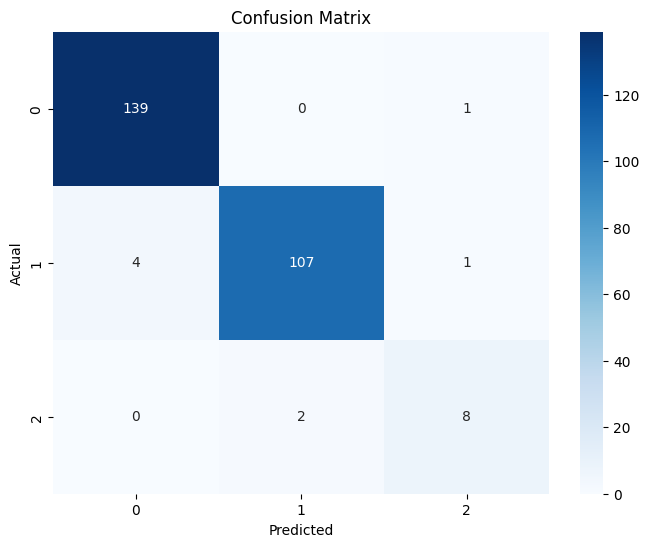

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from deap import base, creator, tools, algorithms
import random

# Load the final cleaned dataset
file_path = '/content/drive/MyDrive/fatty_liver/cleaned_unified_fatty_liver_dataset.xlsx'
df = pd.read_excel(file_path)

# Convert object type columns to strings to ensure uniformity
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype(str).str.strip()

# Drop irrelevant columns like dates
df.drop(columns=['تاریخ تکمیل پرسشنامه', 'تاریخ', 'Abd. Sonography Date', 'Liver Fibroscan Date', 'Liver Biopsy Date', 'HCV ab Date', 'Insulin Level', 'شهر محل سکونت'], inplace=True)

# Handle missing values
for column in df.select_dtypes(include=['number']).columns:
    df[column].fillna(df[column].median(), inplace=True)
for column in df.select_dtypes(include=['object']).columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# Encode categorical variables using LabelEncoder
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

# Define features and target variable
X = df.drop(columns=["Unified Liver Grade"])
y = df["Unified Liver Grade"] - 1  # Adjust labels to be zero-indexed

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SMOTE + ENN to balance the classes
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the resampled data into training and testing sets (80/20 division)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the DEAP fitness and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define the hyperparameter search space
def create_individual():
    return [
        random.randint(50, 200),  # n_estimators
        random.randint(3, 7),     # max_depth
        random.uniform(0.01, 0.2),  # learning_rate
        random.uniform(0.6, 1.0),   # subsample
        random.uniform(0.6, 1.0),   # colsample_bytree
        random.uniform(0, 0.2),     # gamma
        max(0, random.uniform(0, 0.5)),     # reg_alpha must be >= 0
        max(0, random.uniform(0.1, 10))     # reg_lambda must be >= 0
    ]

# Evaluate the F1 score of the XGBoost model
def evaluate_individual(individual):
    n_estimators, max_depth, learning_rate, subsample, colsample_bytree, gamma, reg_alpha, reg_lambda = individual
    model = XGBClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        eval_metric='mlogloss'
    )
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted').mean()
    return cv_score,

# Register the genetic algorithm operators
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_individual)

# Function to ensure individuals remain within valid parameter bounds
def ensure_bounds(individual):
    # Ensure the parameters stay within their respective bounds
    individual[0] = int(max(50, min(individual[0], 200)))  # n_estimators
    individual[1] = int(max(3, min(individual[1], 7)))  # max_depth
    individual[2] = max(0.01, min(individual[2], 0.2))  # learning_rate
    individual[3] = max(0.6, min(individual[3], 1.0))  # subsample
    individual[4] = max(0.6, min(individual[4], 1.0))  # colsample_bytree
    individual[5] = max(0, min(individual[5], 0.2))  # gamma
    individual[6] = max(0, individual[6])  # reg_alpha >= 0
    individual[7] = max(0, individual[7])  # reg_lambda >= 0
    return individual

# Apply the 'ensure_bounds' function after mutation and crossover
def mutate_with_bounds(individual, **kwargs):
    tools.mutGaussian(individual, mu=0, sigma=1, indpb=0.2)
    return ensure_bounds(individual),

def mate_with_bounds(ind1, ind2, **kwargs):
    tools.cxBlend(ind1, ind2, alpha=0.5)
    return ensure_bounds(ind1), ensure_bounds(ind2)

toolbox.register("mutate", mutate_with_bounds)
toolbox.register("mate", mate_with_bounds)

# Create an initial population of 50 individuals
population = toolbox.population(n=50)

# Run the genetic algorithm for 20 generations
n_generations = 20
hof = tools.HallOfFame(1)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_generations, halloffame=hof, verbose=True)

# Get the best hyperparameters from the hall of fame
best_individual = hof[0]
best_n_estimators, best_max_depth, best_learning_rate, best_subsample, best_colsample_bytree, best_gamma, best_reg_alpha, best_reg_lambda = best_individual

# Train the final XGBoost model with the best hyperparameters
best_xgb = XGBClassifier(
    n_estimators=int(best_n_estimators),
    max_depth=int(best_max_depth),
    learning_rate=best_learning_rate,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    gamma=best_gamma,
    reg_alpha=best_reg_alpha,
    reg_lambda=best_reg_lambda,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)
best_xgb.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(best_xgb, X_scaled, y, cv=5, scoring='f1_weighted')

# Predict the test set results
y_pred = best_xgb.predict(X_test)

# Calculate accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Generate a classification report and confusion matrix
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Best Hyperparameters:", best_individual)
print("Cross-Validation F1 Score:", cv_scores.mean())
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
